In [1]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import utils
import graphviz
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
import ast
import load_data

FILE_NAME = "census_income"

In [2]:
X, y , sensitive = load_data.census()
print(utils.discrimination(y, sensitive))

0.19637403845538565


In [3]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

In [4]:


from tqdm.notebook import tqdm
from multiprocessing import Process, Pool
from functools import partial

result = pd.DataFrame(columns=
                      ["k", "depth", "random_state", "clf.error_", "clf.accuracy_","confusion", "accuracy_pred", "accuracy_test", "sum_misclassified_train",
                        "discrimination_train",       "sum_discrimination_additive_train",      "sum_discrimination_additive_train_abs",
                        "discrimination_train_pred",  "sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs",
                        "discrimination_test",        "sum_discrimination_additive_test_pred",  "sum_discrimination_additive_test_pred_abs",
                        "duration", "min_supp", "clf.tree_"])

def xx(min_supp, random_state, X_train, X_test, y_train, y_test, sensitive_train, sensitive_test, depth, k):

    clf = DL85Classifier(max_depth=depth, error_function=lambda tids: utils.error(list(tids), k, y_train, sensitive_train), min_sup=min_supp, time_limit=300)

    start = time.perf_counter()
    clf.fit(X_train, list(y_train))
    duration = time.perf_counter() - start
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    accuracy_pred = round(accuracy_score(y_train, y_pred_train), 8)
    accuracy_test = round(accuracy_score(y_test, y_pred_test), 8)
    discrimination_train = round(utils.discrimination(y_train, sensitive_train), 8)
    discrimination_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 8)
    discrimination_test = round(utils.discrimination(y_pred_test, sensitive_test), 8)

    utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
    sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False),8)
    sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True),8)

    sum_discrimination_additive_train = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=False),8)
    sum_discrimination_additive_train_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=True),8)
    sum_misclassified_train = round(utils.sum_elem_tree(clf.tree_, 'misclassified'),8)

    discri_test= list()
    utils.get_discri_test(clf.tree_, X_test, y_pred_test, sensitive_test, discri_test, X.columns, path=None)
    sum_discrimination_additive_test_pred = sum(discri_test)
    sum_discrimination_additive_test_pred_abs = 0
    [sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]
    #print(f"### Depth: {depth} state: {random_state} k:{k} ###")

    return [k, depth, random_state, clf.error_, clf.accuracy_, utils.perf_measure(y_train, y_pred_train, sensitive_train), accuracy_pred, accuracy_test, sum_misclassified_train,
            discrimination_train,       sum_discrimination_additive_train,      sum_discrimination_additive_train_abs,
            discrimination_train_pred,  sum_discrimination_additive_train_pred, sum_discrimination_additive_train_pred_abs,
            discrimination_test,        sum_discrimination_additive_test_pred,  sum_discrimination_additive_test_pred_abs,
            duration, min_supp, clf.tree_]

pool = Pool()
if False:
    #result = pd.read_csv('save/'+FILE_NAME+".csv")
    min_supp = 2
    args = []
    for depth in [1, 2, 3, 4, 5 , 6 , 7]:
        for k in [0, 1000, 2000, 3000, 4000, 5000, 10000, 100000]:
            args.append((depth, k))
    for random_state in tqdm(range(2, 102, 5)):
        if random_state in [27,67]:
                continue
        X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)
        
        print(f"random state: {random_state}")

        for res in pool.starmap(partial(xx, min_supp, random_state, X_train, X_test, y_train, y_test, sensitive_train, sensitive_test), tqdm(args)):
            result.loc[len(result.index)] = res

    result = result.sort_values(['k', 'depth', 'min_supp'])
    result.to_csv('save/'+FILE_NAME+'.csv', index=False)
    
result = pd.read_csv('save/'+FILE_NAME+".csv")
print(result)

  0%|          | 0/20 [00:00<?, ?it/s]

random state: 2


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 7


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 12


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 17


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 22


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 32


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 37


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 42


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 47


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 52


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 57


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 62


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 72


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 77


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 82


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 87


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 92


  0%|          | 0/56 [00:00<?, ?it/s]

random state: 97


  0%|          | 0/56 [00:00<?, ?it/s]

           k  depth  random_state    clf.error_  clf.accuracy_  \
0          0      1             2   2856.000000       0.762948   
1          0      1             7   2842.000000       0.764110   
2          0      1            12   2900.000000       0.759296   
3          0      1            17   2860.000000       0.762616   
4          0      1            22   2839.000000       0.764359   
...      ...    ...           ...           ...            ...   
1003  100000      7            77  22587.359375      -0.874781   
1004  100000      7            82  22625.882812      -0.877978   
1005  100000      7            87  22718.210938      -0.885642   
1006  100000      7            92  22454.396484      -0.863745   
1007  100000      7            97  22153.054688      -0.838733   

                                          confusion  accuracy_pred  \
0      ((140, 32, 2386, 5580), (15, 11, 427, 3457))       0.762948   
1      ((123, 32, 2371, 5610), (15, 12, 427, 3458))       0.764110 

In [5]:
result = pd.read_csv('save/'+FILE_NAME+".csv")
result

,k,depth,random_state,clf.error_,clf.accuracy_,confusion,accuracy_pred,accuracy_test,sum_misclassified_train,discrimination_train,...,sum_discrimination_additive_train_abs,discrimination_train_pred,sum_discrimination_additive_train_pred,sum_discrimination_additive_train_pred_abs,discrimination_test,sum_discrimination_additive_test_pred,sum_discrimination_additive_test_pred_abs,duration,min_supp,clf.tree_
0,0,1,2,2856.000000,0.762948,"((140, 32, 2386, 5580), (15, 11, 427, 3457))",0.762948,0.762616,2856,0.197352,...,0.197352,0.014486,0.014486,0.014486,0.005957,0.005957,0.005957,6.711812,2,"{'feat': 19, 'left': {'value': 1, 'error': 43...."
1,0,1,7,2842.000000,0.764110,"((123, 32, 2371, 5610), (15, 12, 427, 3458))",0.764110,0.757968,2842,0.193553,...,0.193553,0.012149,0.012149,0.012149,0.015371,0.015371,0.015371,7.420070,2,"{'feat': 19, 'left': {'value': 1, 'error': 44...."
2,0,1,12,2900.000000,0.759296,"((138, 33, 2427, 5547), (12, 13, 427, 3451))",0.759296,0.777224,2900,0.202440,...,0.202440,0.014589,0.014589,0.014589,0.005601,0.005601,0.005601,7.390028,2,"{'feat': 19, 'left': {'value': 1, 'error': 46...."
3,0,1,17,2860.000000,0.762616,"((124, 34, 2388, 5570), (16, 15, 424, 3477))",0.762533,0.764276,2861,0.197610,...,0.197610,0.011584,0.011584,0.011584,0.017517,0.017517,0.017517,7.518325,2,"{'feat': 19, 'left': {'value': 1, 'error': 48...."
4,0,1,22,2839.000000,0.764359,"((137, 29, 2391, 5586), (18, 14, 405, 3468))",0.764359,0.756972,2839,0.202128,...,0.202128,0.012191,0.012191,0.012191,0.015000,0.015000,0.015000,7.288748,2,"{'feat': 19, 'left': {'value': 1, 'error': 43...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,100000,7,77,22587.359375,-0.874781,"((328, 215, 2176, 5365), (35, 51, 410, 3468))",0.763280,0.758300,2852,0.197487,...,0.197487,0.045474,0.045474,0.045474,0.043563,0.043563,0.043900,310.898736,2,"{'feat': 0, 'left': {'value': 0, 'error': 904...."
1004,100000,7,82,22625.882812,-0.877978,"((329, 201, 2182, 5395), (35, 56, 405, 3445))",0.763944,0.752324,2844,0.198086,...,0.198086,0.042285,0.042285,0.042285,0.036928,0.036928,0.043488,310.331775,2,"{'feat': 0, 'left': {'value': 0, 'error': 1102..."
1005,100000,7,87,22718.210938,-0.885642,"((386, 242, 2108, 5298), (40, 56, 406, 3512))",0.766600,0.752988,2812,0.199320,...,0.199321,0.054251,0.054251,0.055002,0.049689,0.049689,0.056411,312.198988,2,"{'feat': 0, 'left': {'value': 0, 'error': 1256..."
1006,100000,7,92,22454.396484,-0.863745,"((389, 252, 2116, 5384), (42, 59, 392, 3414))",0.766019,0.758300,2819,0.196619,...,0.196742,0.052886,0.052886,0.052886,0.062361,0.062361,0.065334,311.131672,2,"{'feat': 0, 'left': {'value': 0, 'error': 1017..."


accuracy_pred = 0.79614874
accuracy_test = 0.80312085
discrimination_train = 0.19722738
discrimination_train_pred = 0.09643221


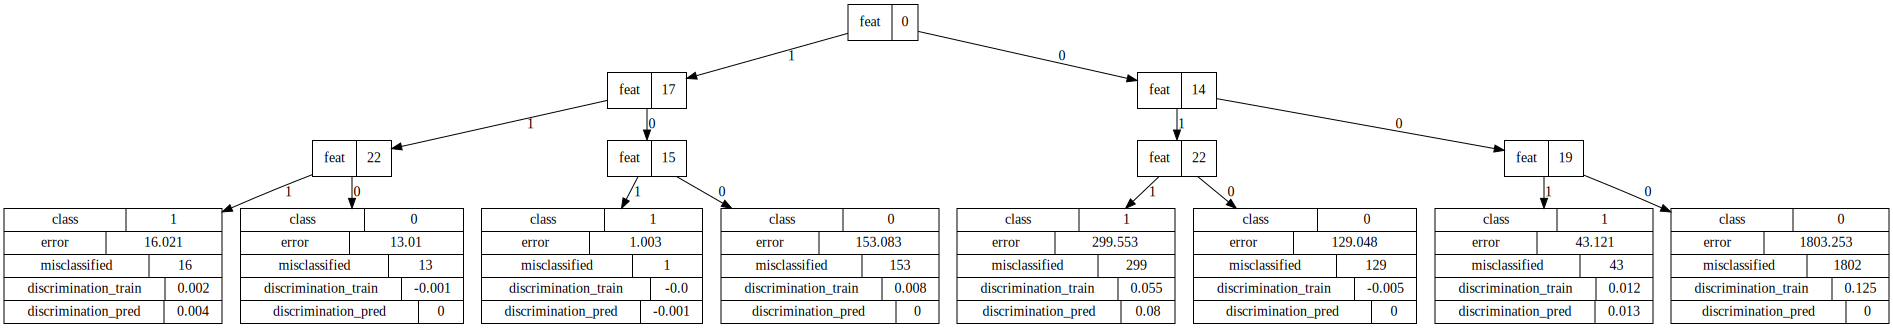

In [6]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.error(list(tids), 10, y_train, sensitive_train), min_sup=1, time_limit=300)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(f'accuracy_pred = {round(accuracy_score(y_train, y_pred_train), 8)}')
print(f'accuracy_test = {round(accuracy_score(y_test, y_pred_test), 8)}')
print(f'discrimination_train = {round(utils.discrimination(y_train, sensitive_train), 8)}')
print(f'discrimination_train_pred = {round(utils.discrimination(y_pred_train, sensitive_train), 8)}')

utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)


In [7]:
discri_test= list()
utils.get_discri_test(clf.tree_, X_test, y_test, sensitive_test, discri_test, X.columns, path=None)
sum_discrimination_additive_test_pred = sum(discri_test)
sum_discrimination_additive_test_pred_abs = 0
[sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]
print(sum_discrimination_additive_test_pred)
sum_discrimination_additive_test_pred_abs

0.19311822800063677


0.21125212341285593

In [8]:
discri_test

[0.003253380835984871,
 -0.004642793091427155,
 0.0,
 0.007442776164577341,
 0.055257096682538955,
 -0.004424154614682431,
 0.009677523360060291,
 0.1265543986635849]

In [9]:
utils.discrimination(y_train, sensitive_train)

0.19722738089569225

In [10]:
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_train'))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_train', do_abs=True))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_pred'))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_pred', do_abs=True))

0.19722738089569222
0.20951296017504079
0.09643220789252152
0.09747662207525284


In [11]:
utils.sum_elem_tree(clf.tree_, 'misclassified')

2456

In [12]:
print(utils.discrimination(y_train, sensitive_train))
print(utils.discrimination(y_pred_train, sensitive_train))
print(utils.discrimination(y_test, sensitive_test))
print(utils.discrimination(y_pred_test, sensitive_test))

0.19722738089569225
0.09643220789252152
0.19311822800063677
0.09007905241882669


In [13]:
clf.tree_

{'feat': 0,
 'left': {'feat': 17,
  'left': {'feat': 22,
   'left': {'value': 1,
    'error': 16.021112,
    'transactions': [2573,
     6672,
     9235,
     5657,
     11300,
     4138,
     1070,
     7215,
     10815,
     11849,
     4682,
     8272,
     7260,
     7782,
     10855,
     8813,
     626,
     10365,
     3198,
     1665,
     2692,
     10891,
     11917,
     4238,
     4751,
     7318,
     4759,
     10400,
     9890,
     7844,
     11942,
     10923,
     4783,
     5311,
     9925,
     10442,
     4814,
     5843,
     4314,
     3805,
     6368,
     7909,
     1788,
     12028,
     9473,
     4869,
     6918,
     1814,
     2343,
     9000,
     4411,
     6460,
     5956,
     2383,
     8019,
     9571,
     10086,
     8044,
     2936,
     11129,
     7038,
     11653,
     1415,
     8089,
     9116,
     3998,
     4000,
     1443,
     1451,
     10163,
     7094,
     9654,
     4024,
     4541,
     9670,
     5577,
     10190,
     9704,
     

# Graphs

<Figure size 648x432 with 0 Axes>

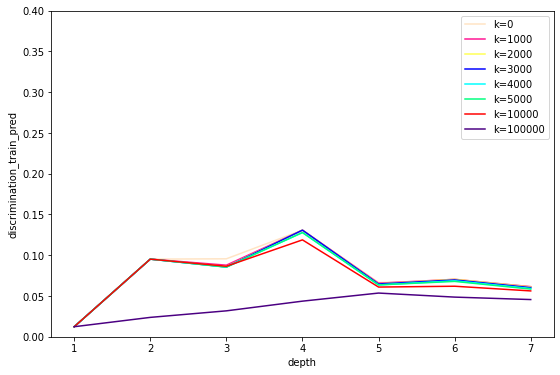

In [14]:
utils.plot_mean("depth", "discrimination_train_pred", result, 0, 0.4)

<Figure size 648x432 with 0 Axes>

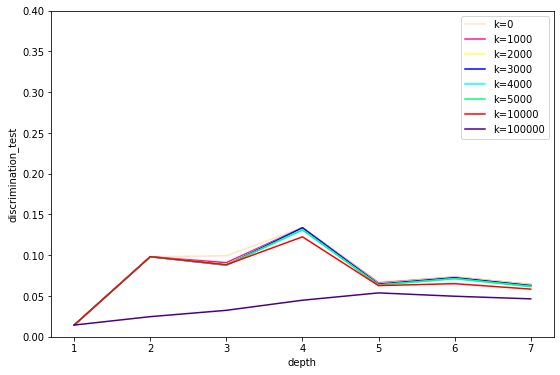

In [15]:
utils.plot_mean("depth", "discrimination_test", result, 0, 0.4)

<Figure size 648x432 with 0 Axes>

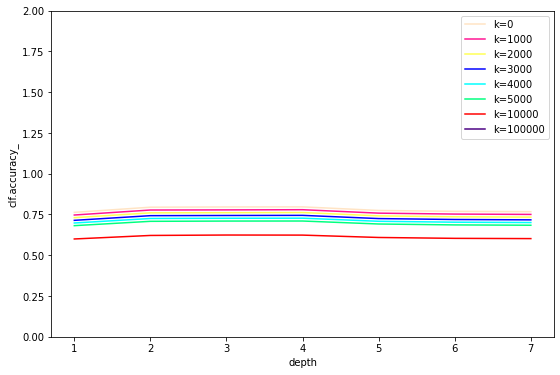

In [16]:
utils.plot_mean("depth", "clf.accuracy_", result, 0, 2)

<Figure size 648x432 with 0 Axes>

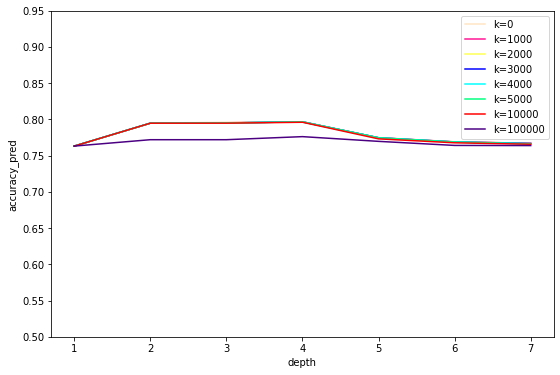

In [17]:
utils.plot_mean("depth", "accuracy_pred", result, 0.5, 0.95)

<Figure size 648x432 with 0 Axes>

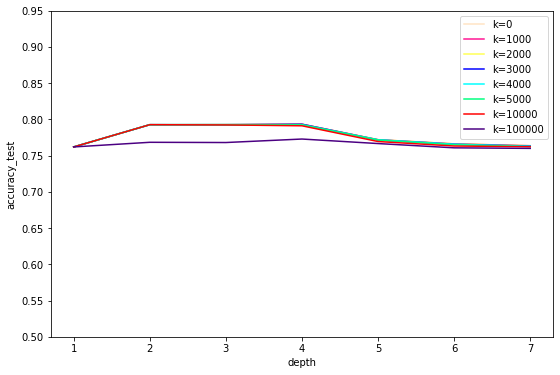

In [18]:
utils.plot_mean("depth", "accuracy_test", result, 0.5, 0.95)

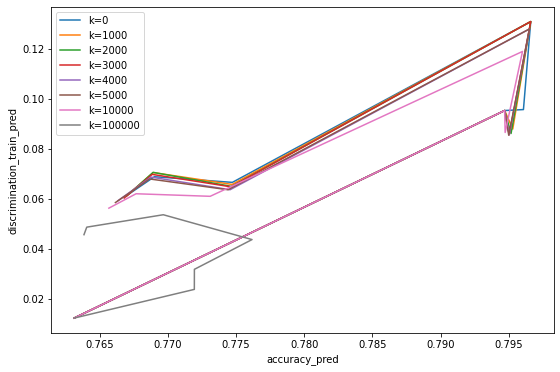

In [19]:
utils.plot2("accuracy_pred", "discrimination_train_pred", result)

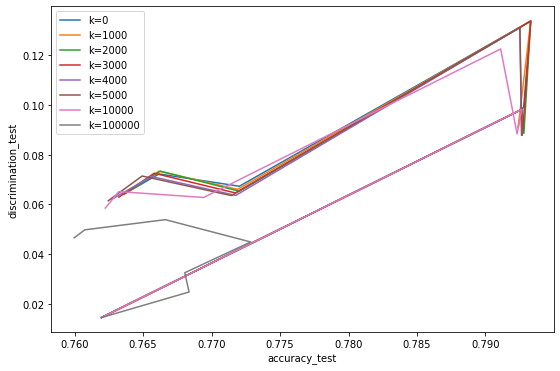

In [20]:
utils.plot2("accuracy_test", "discrimination_test", result)

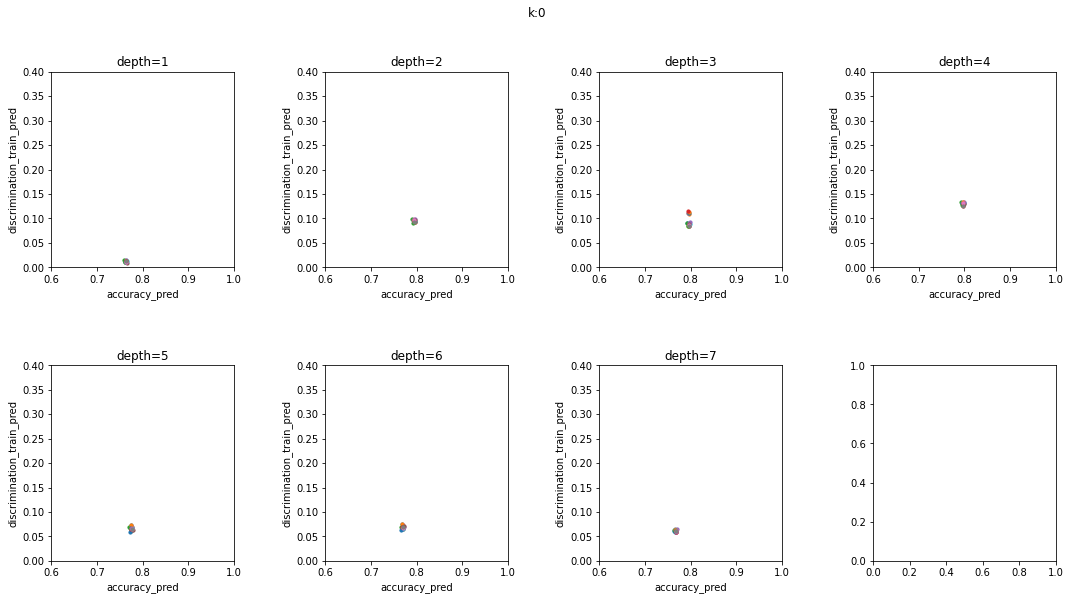

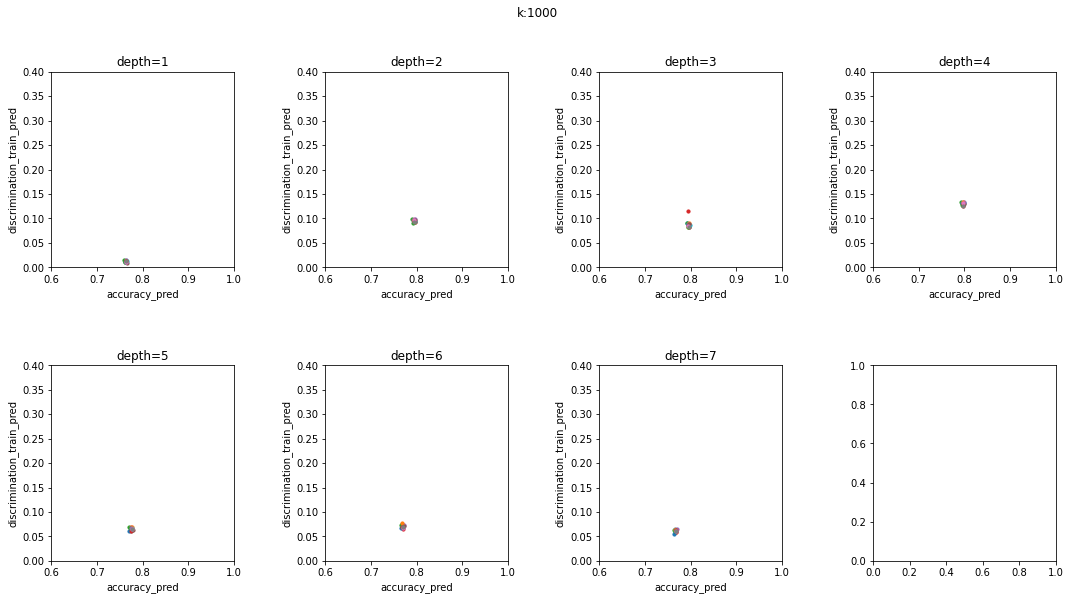

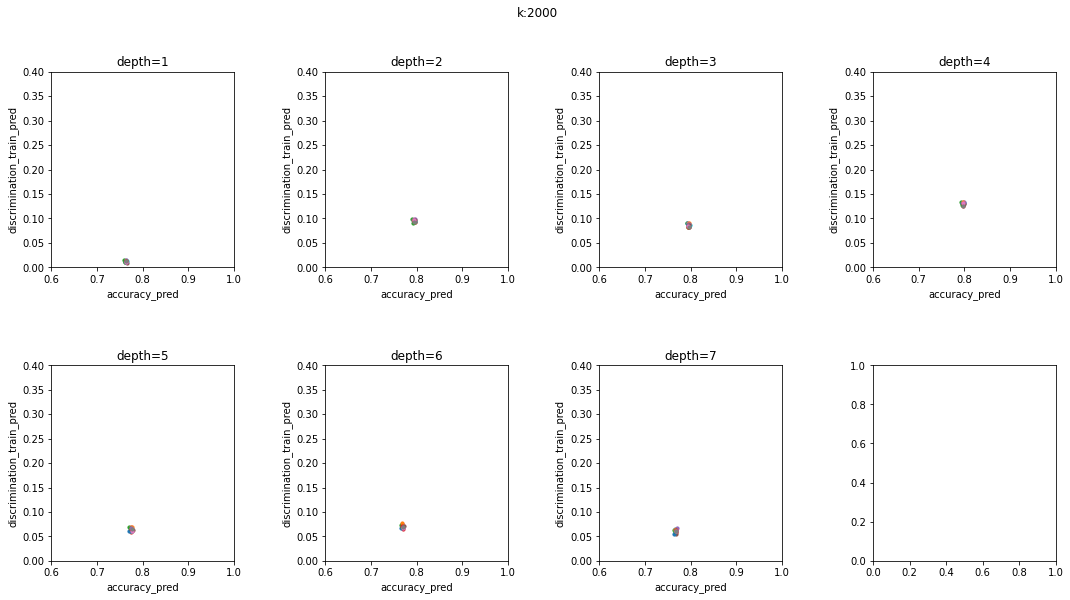

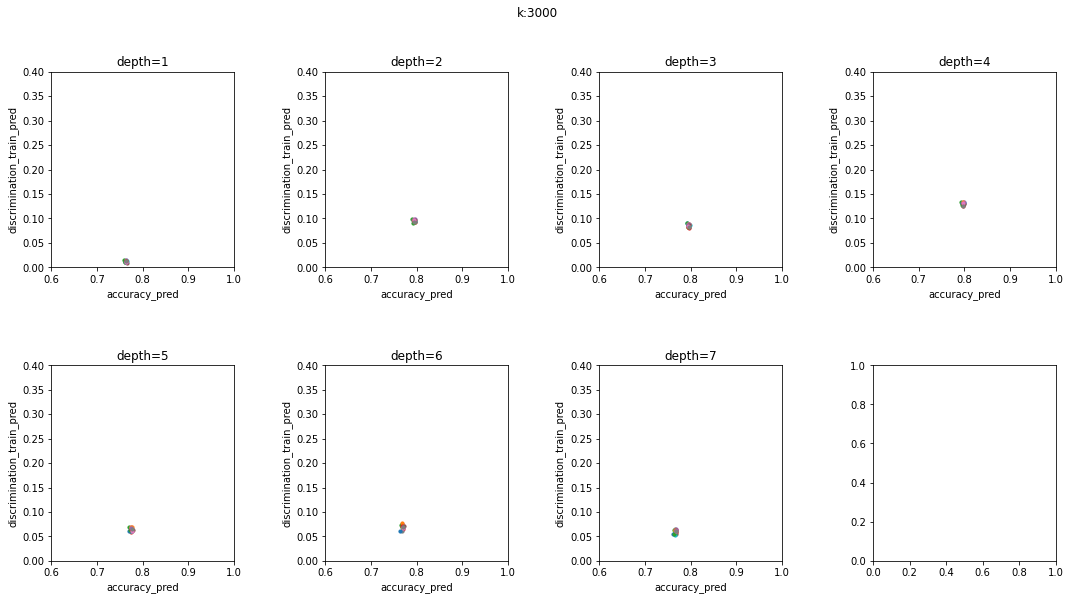

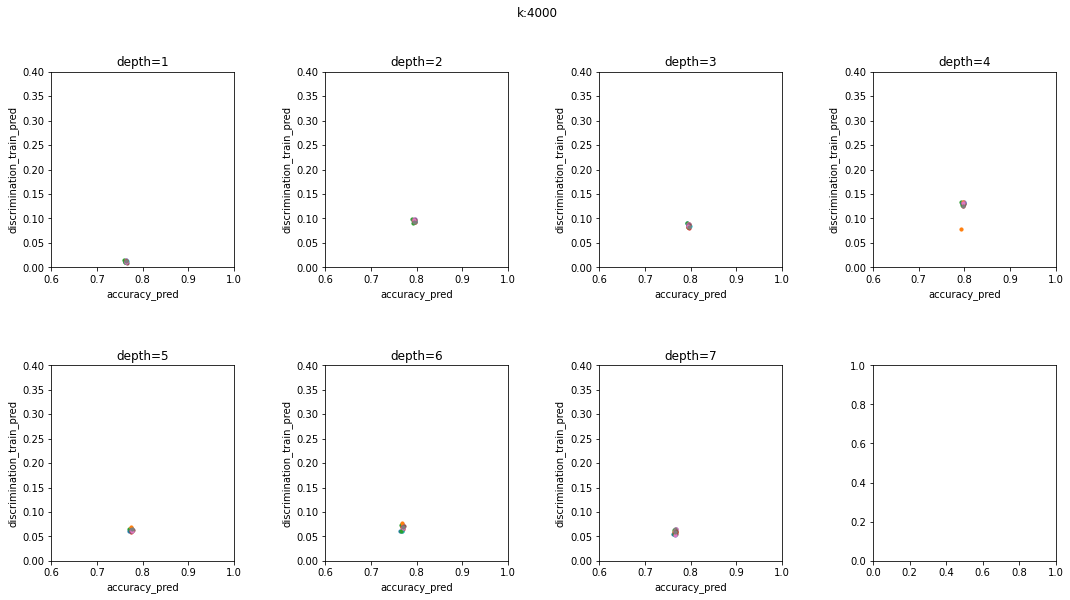

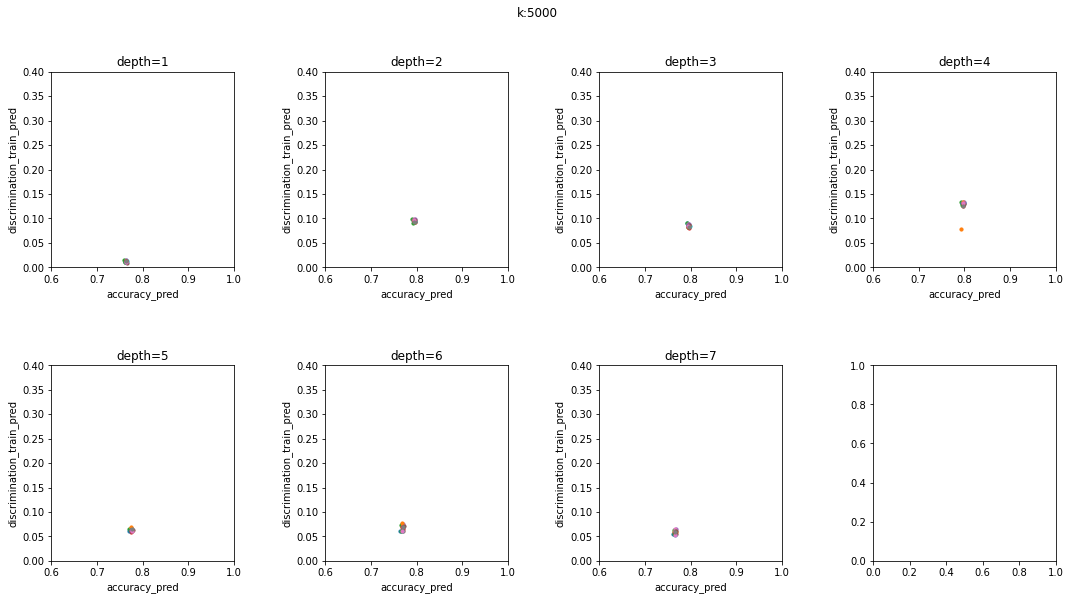

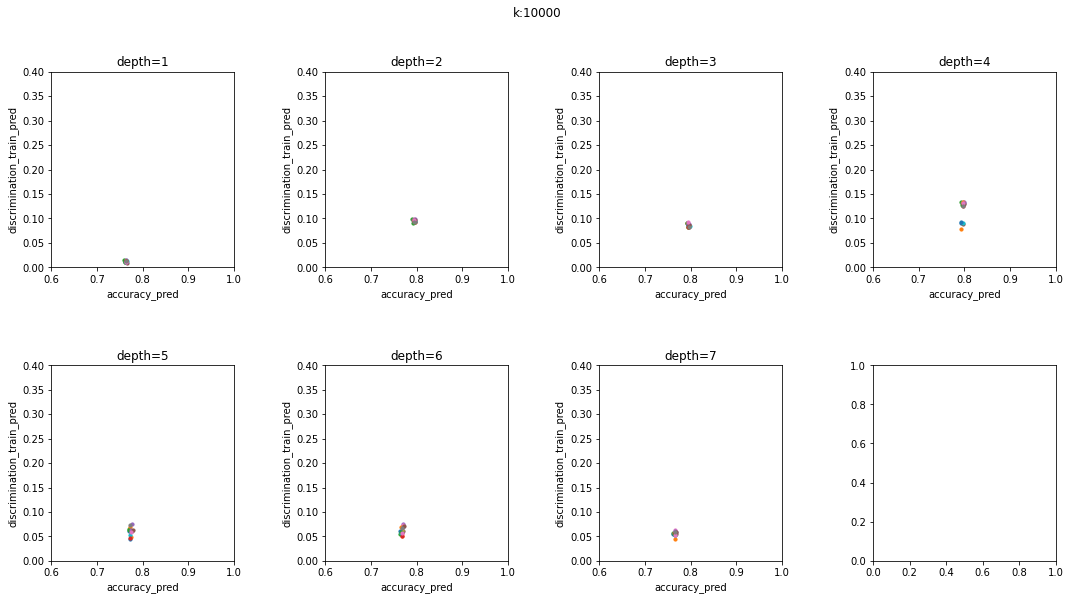

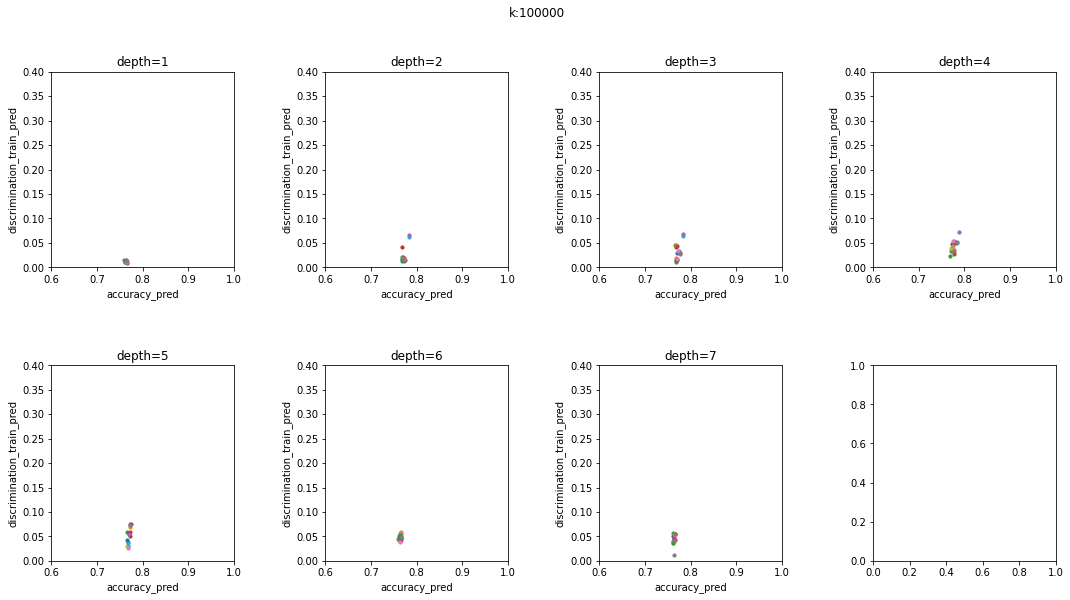

In [21]:
utils.plot_one_scatter_by_depth("accuracy_pred", "discrimination_train_pred", result, (0.6, 1), (0, 0.4))

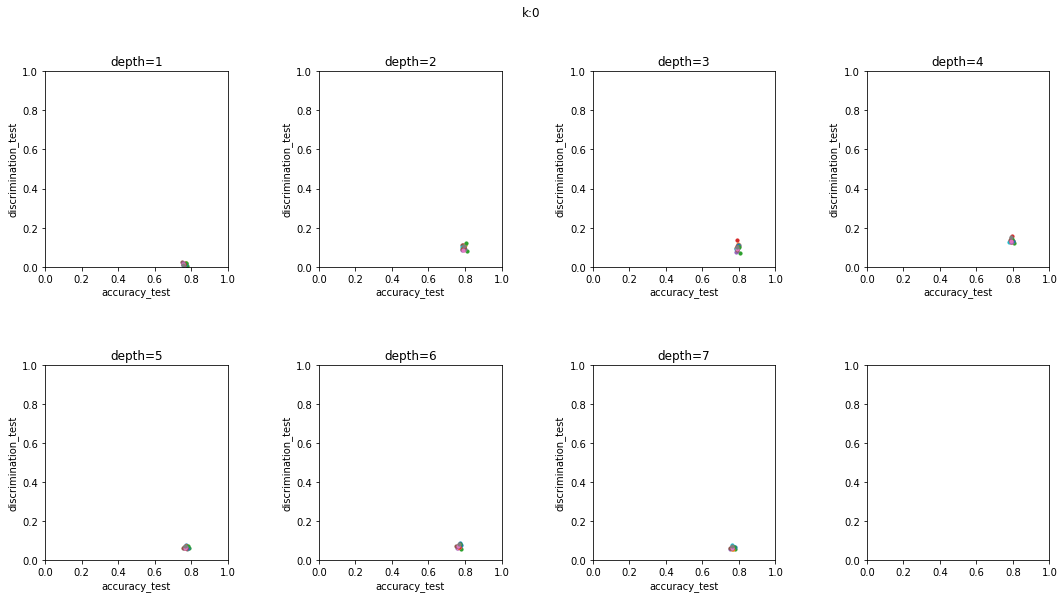

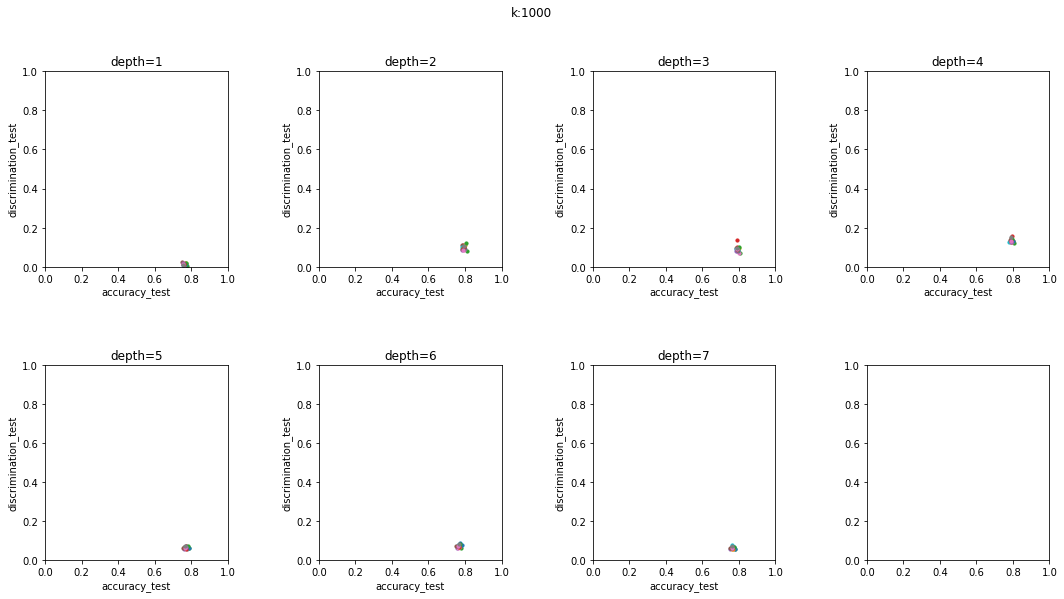

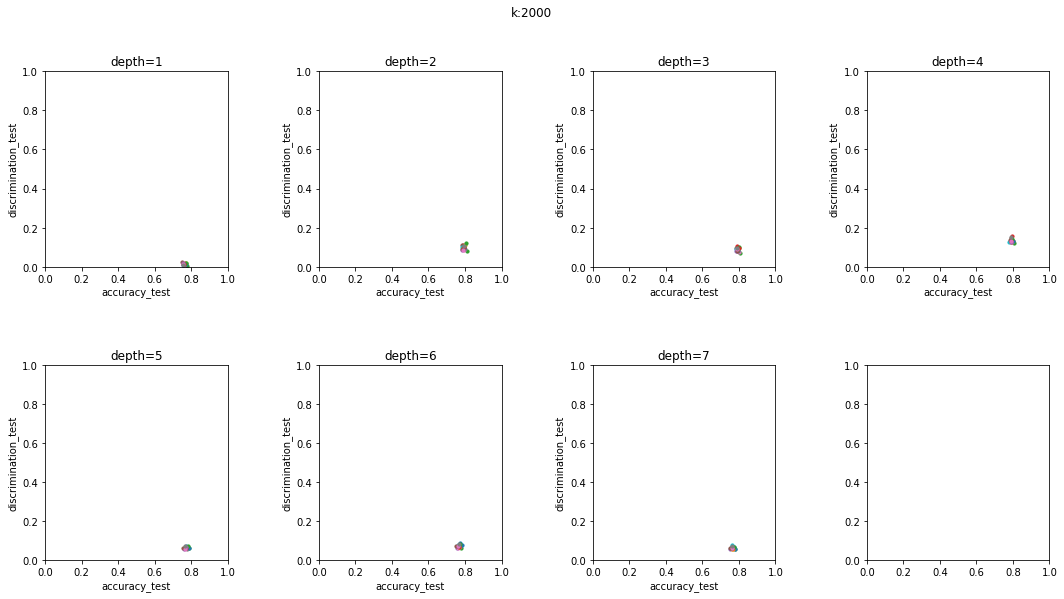

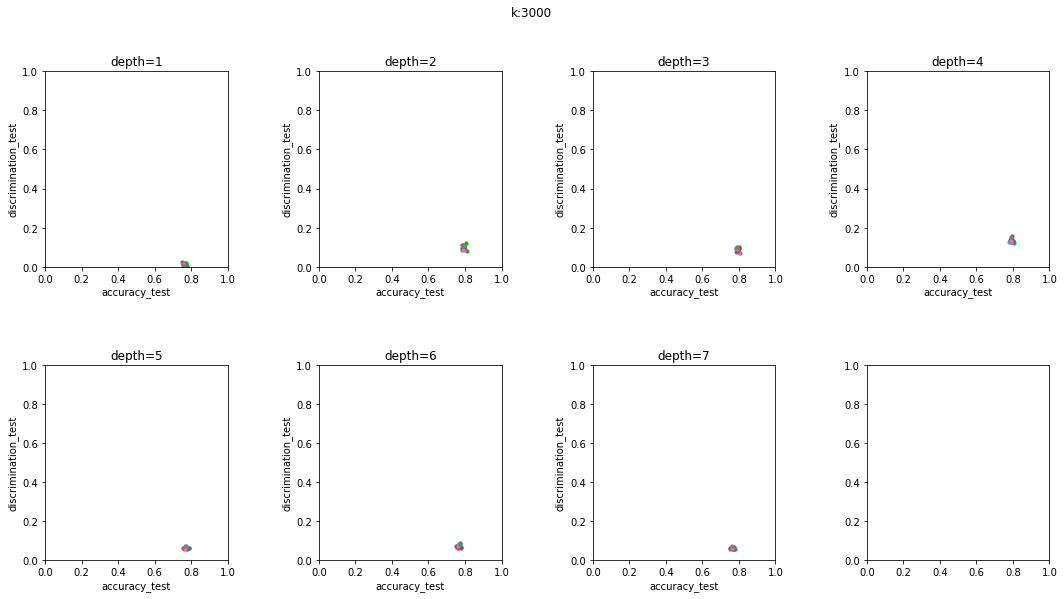

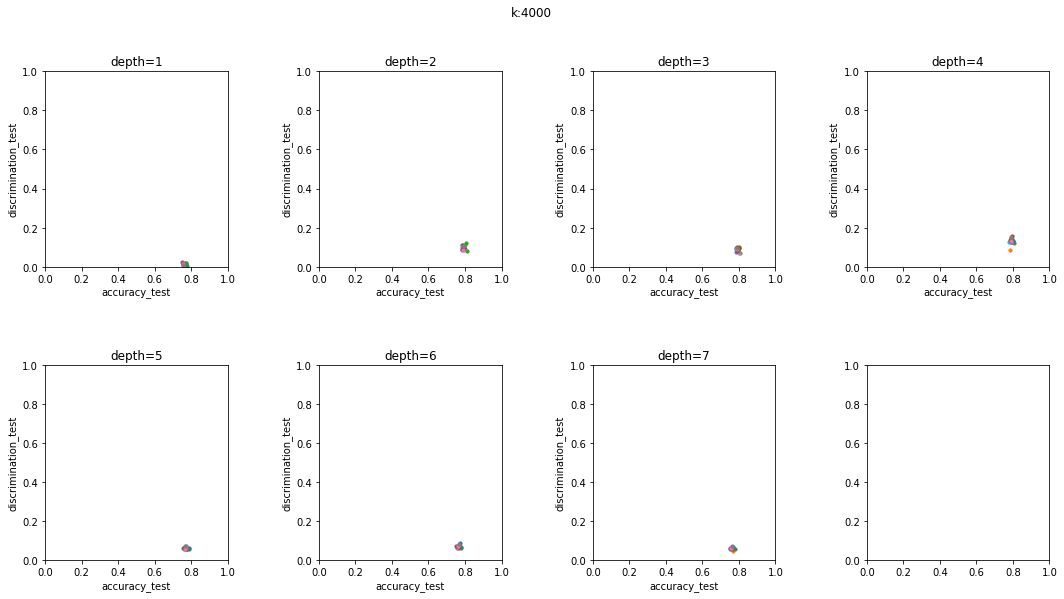

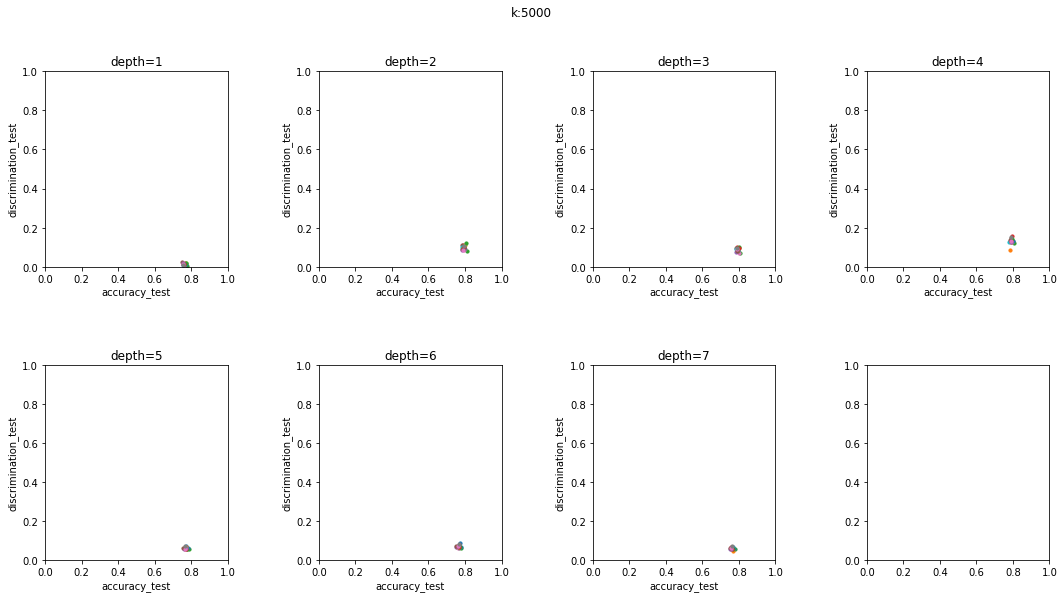

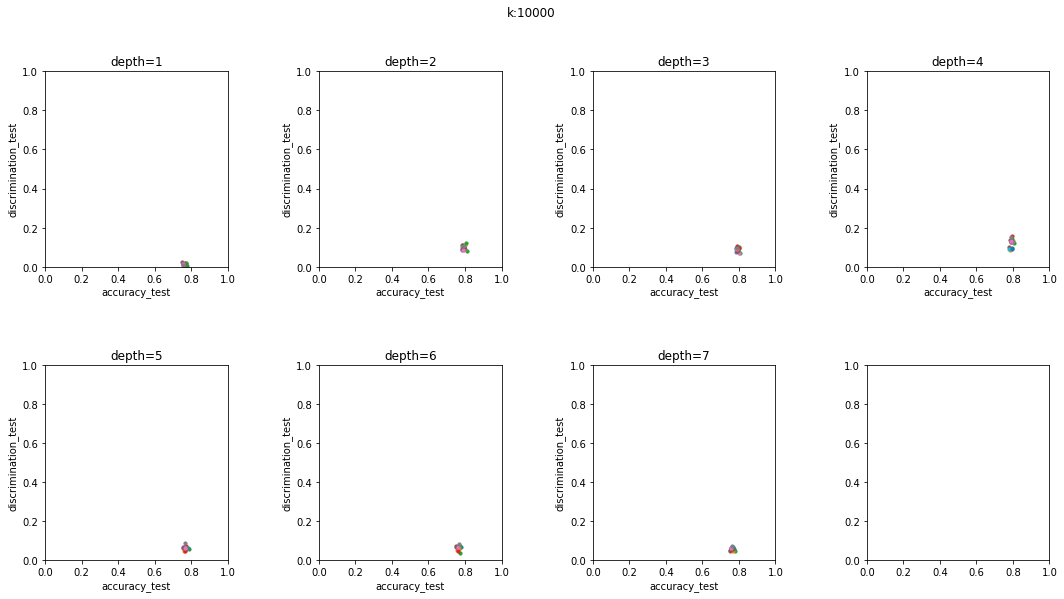

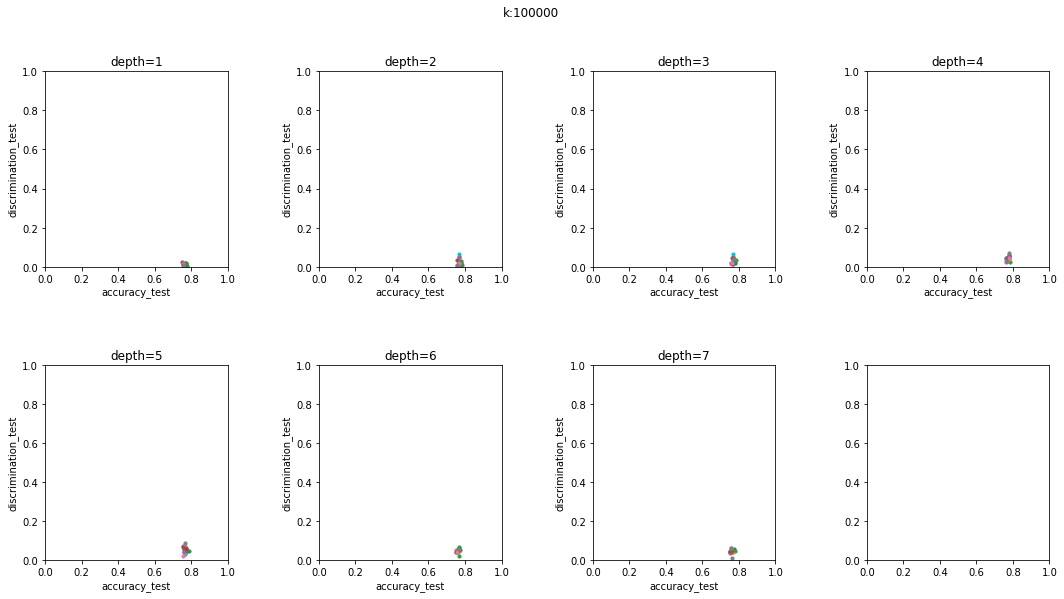

In [22]:
utils.plot_one_scatter_by_depth("accuracy_test", "discrimination_test", result, (0, 1), (0, 1))

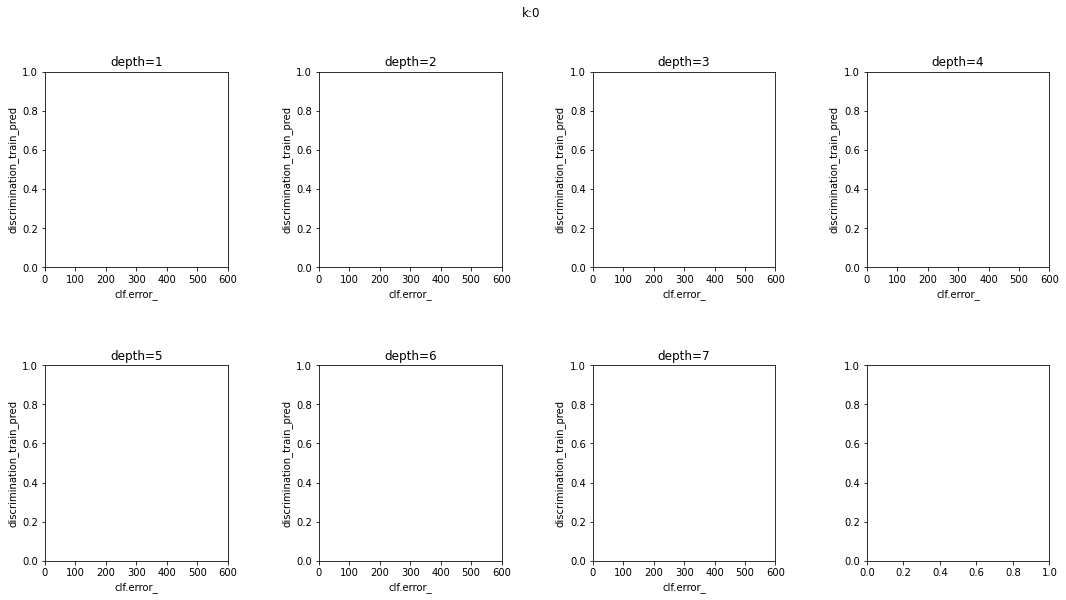

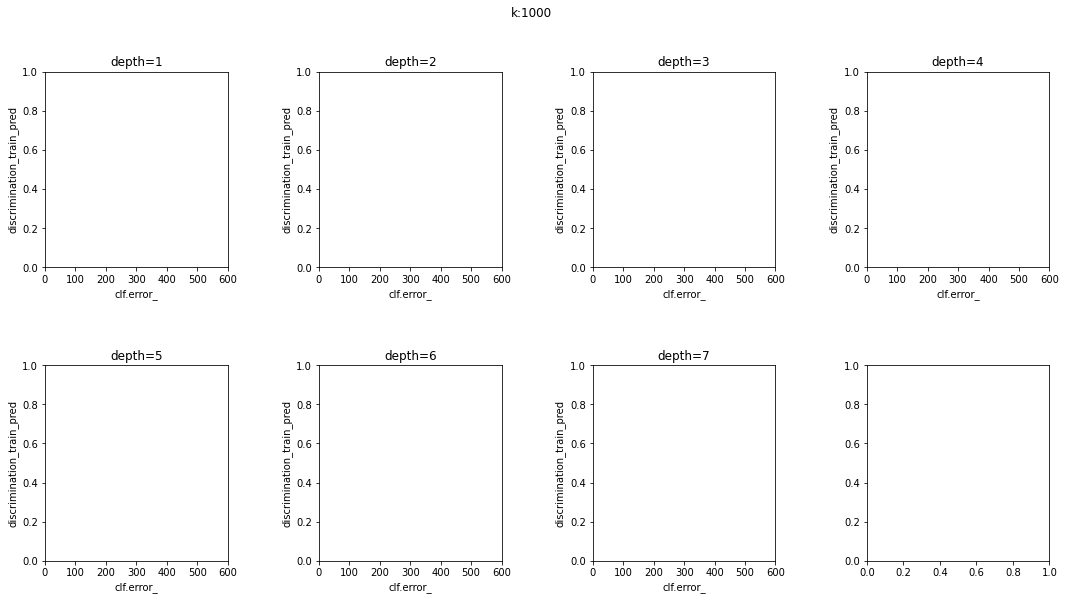

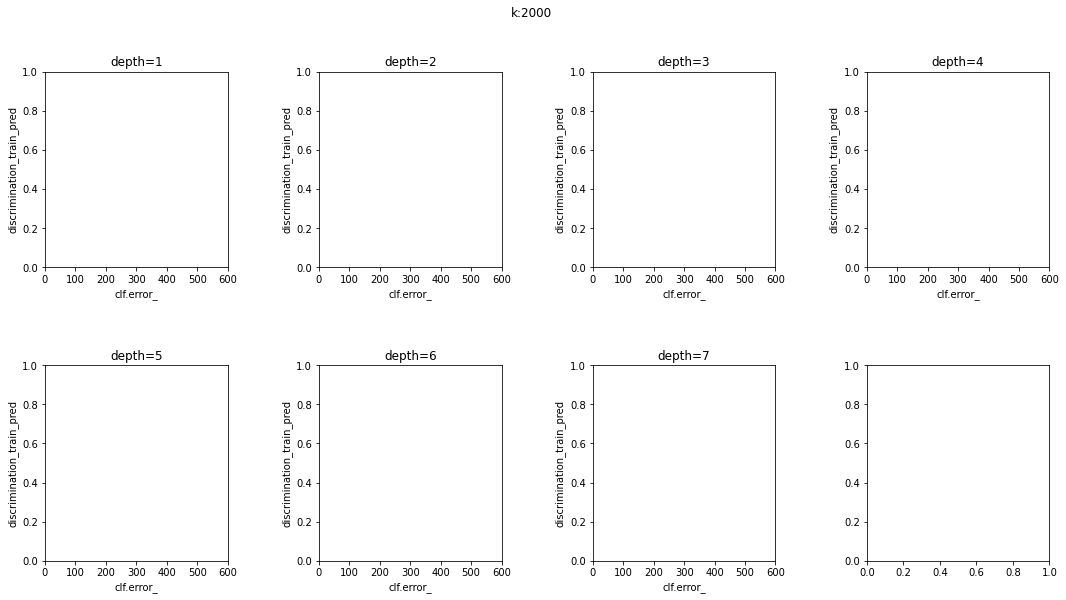

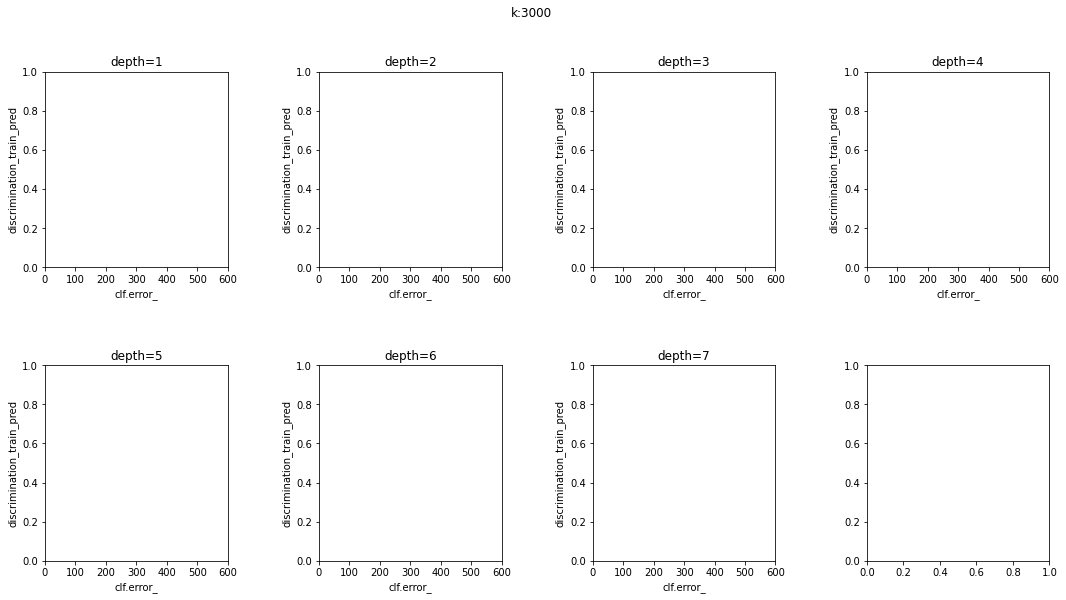

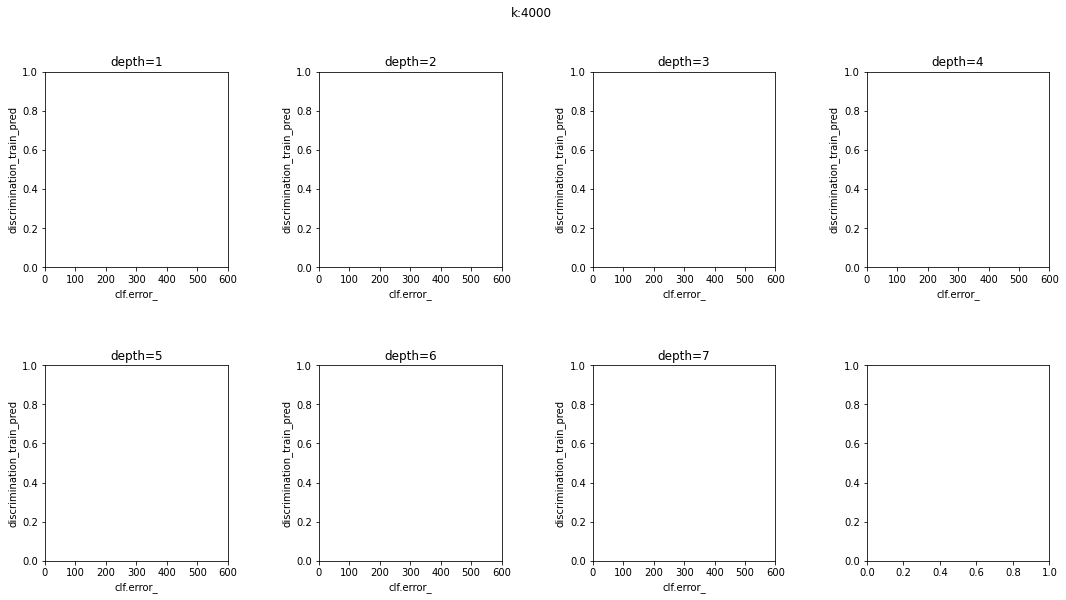

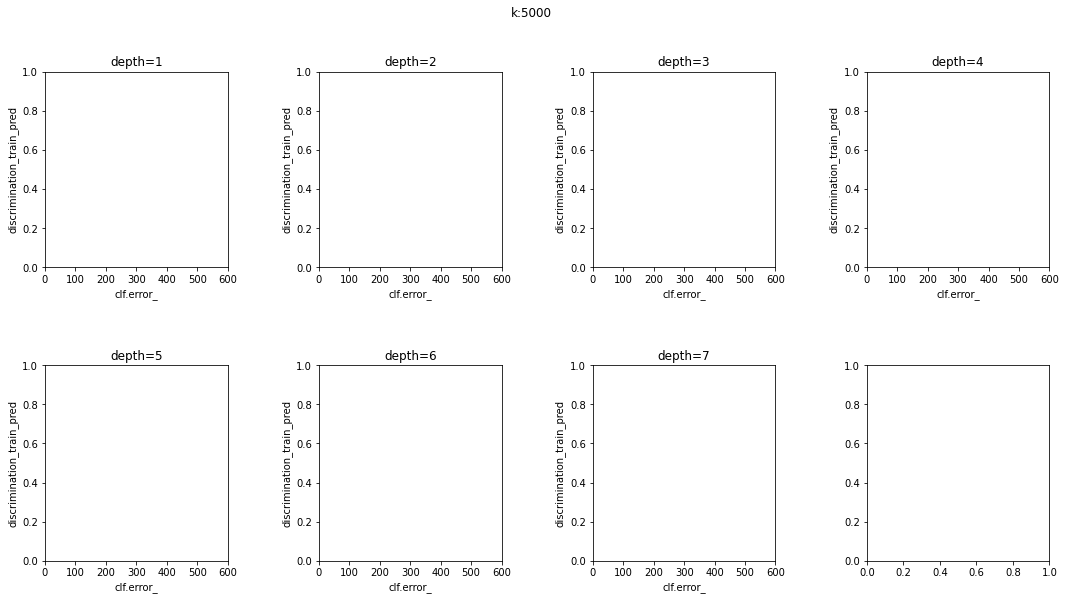

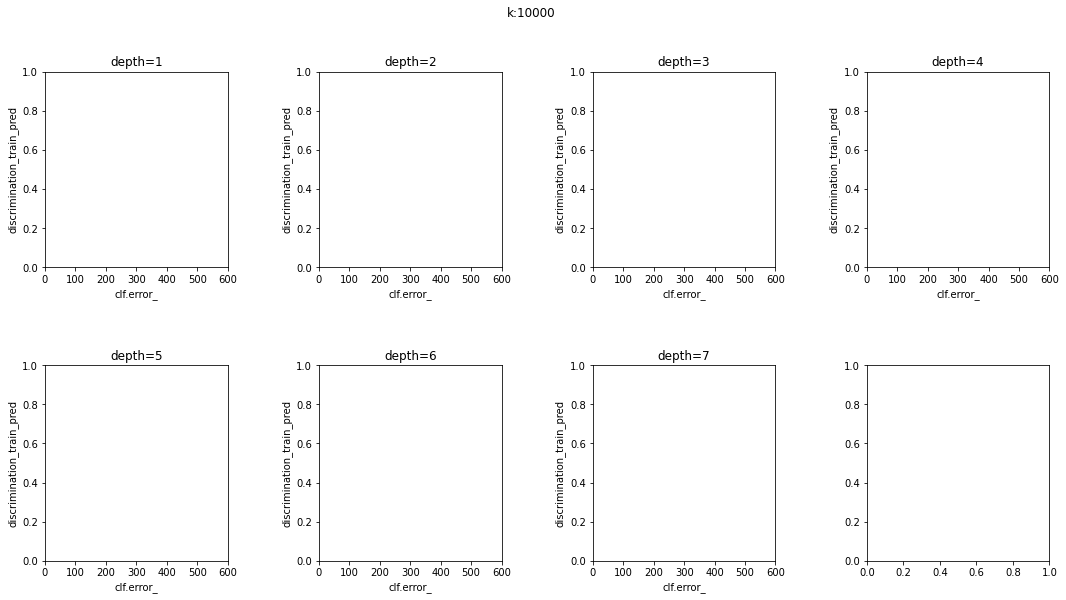

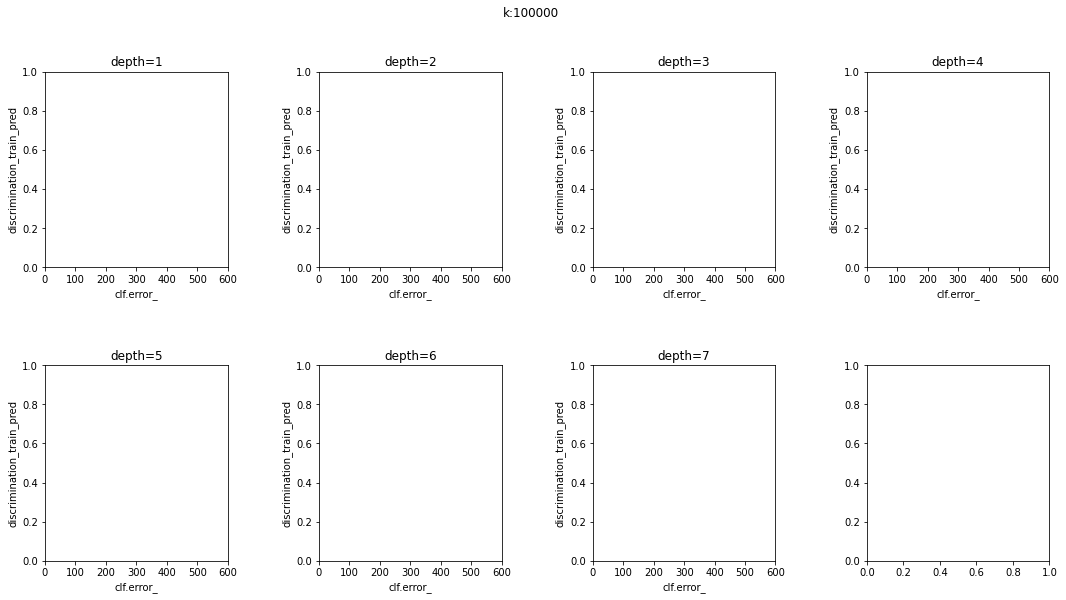

In [23]:
utils.plot_one_scatter_by_depth("clf.error_", "discrimination_train_pred", result, (0, 600), (0, 1))

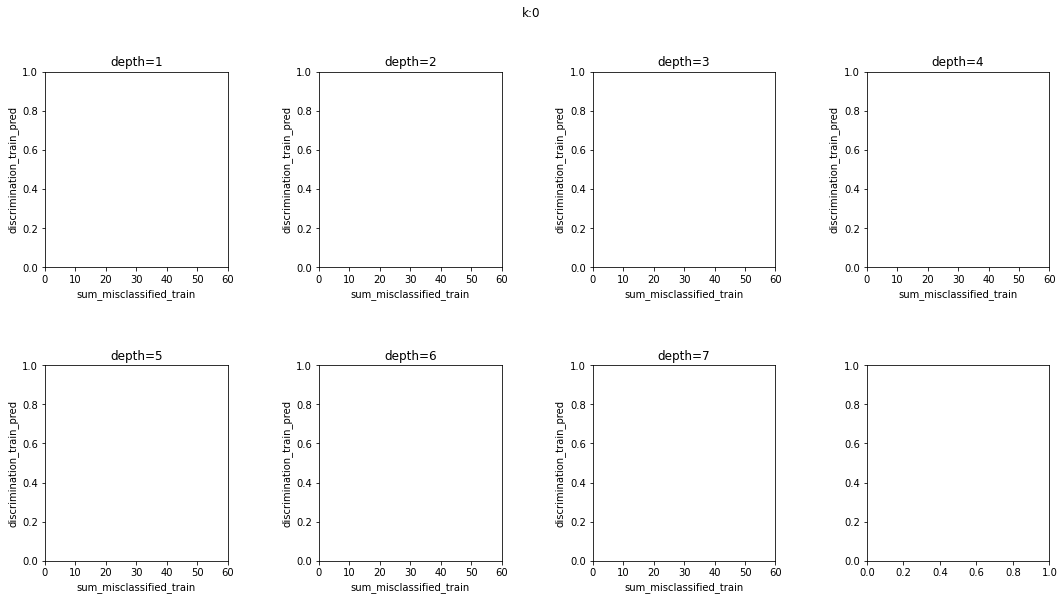

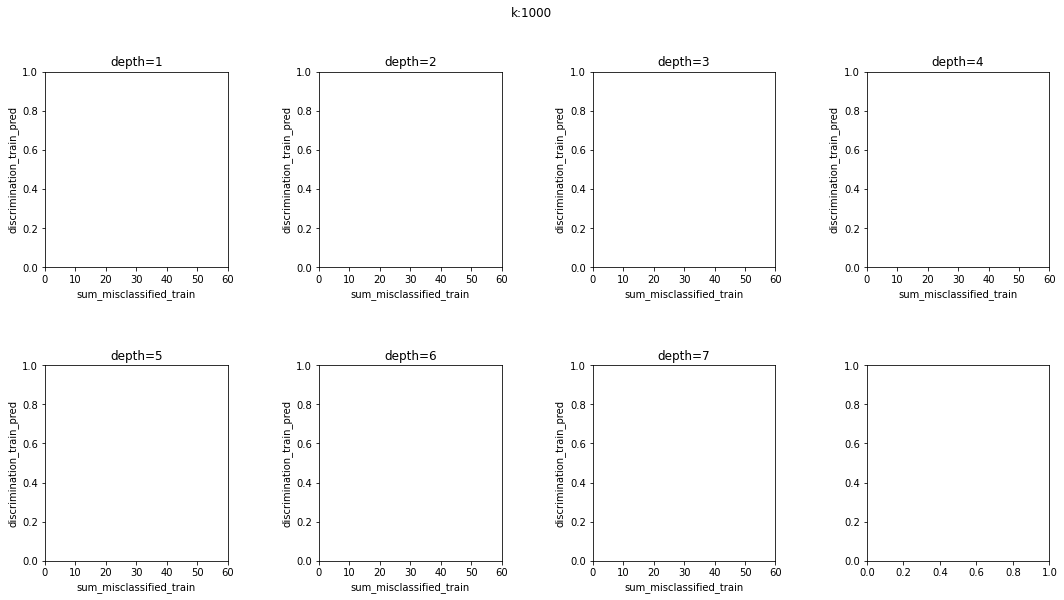

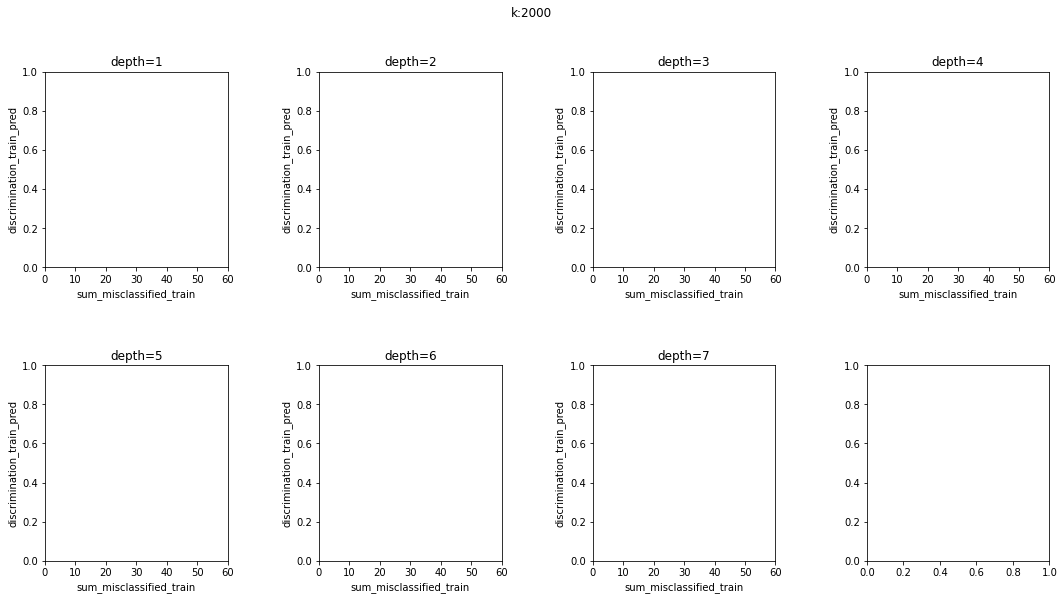

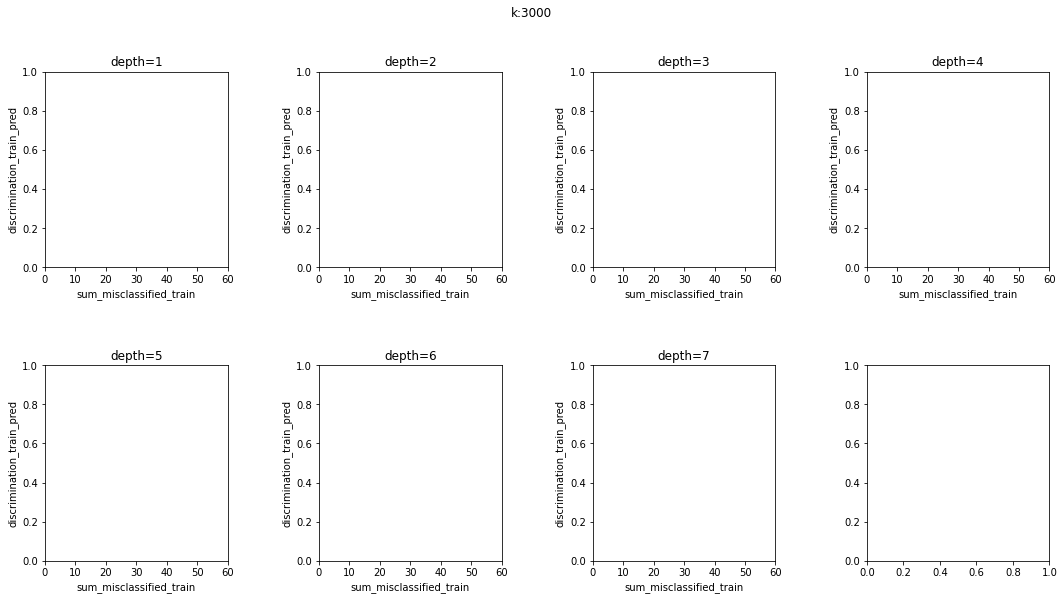

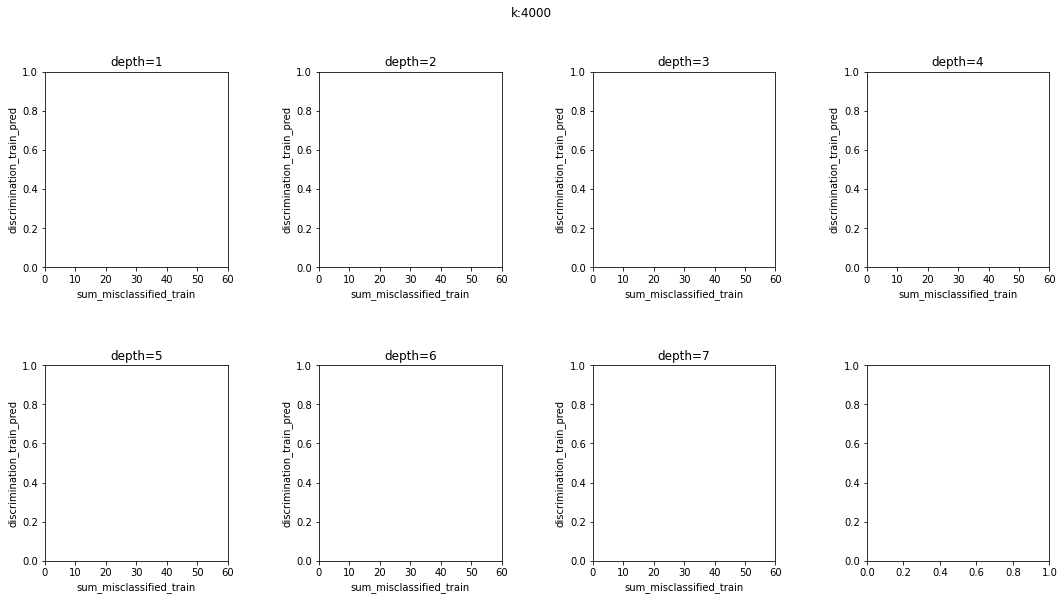

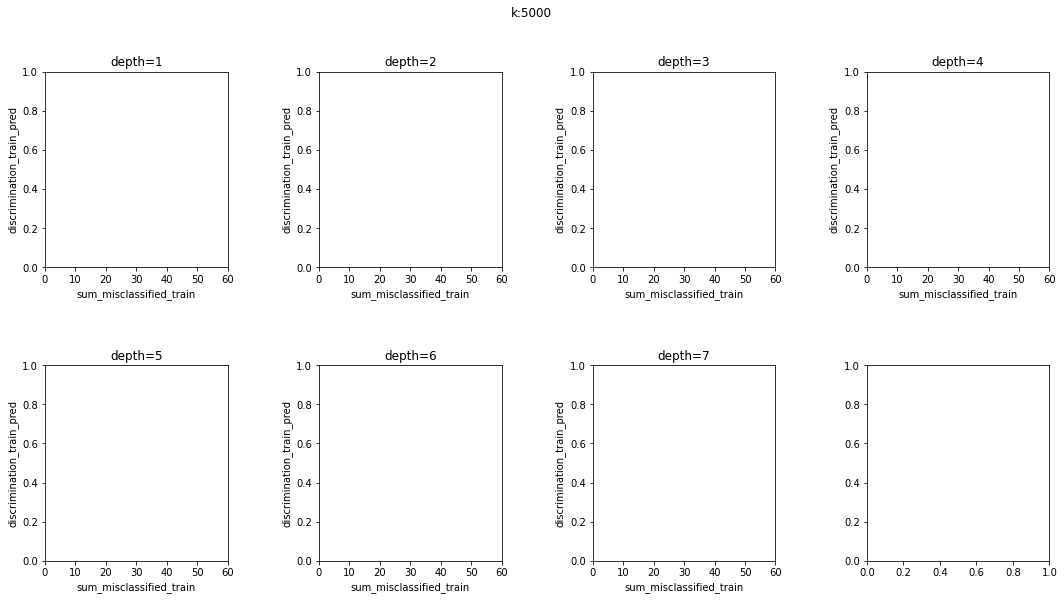

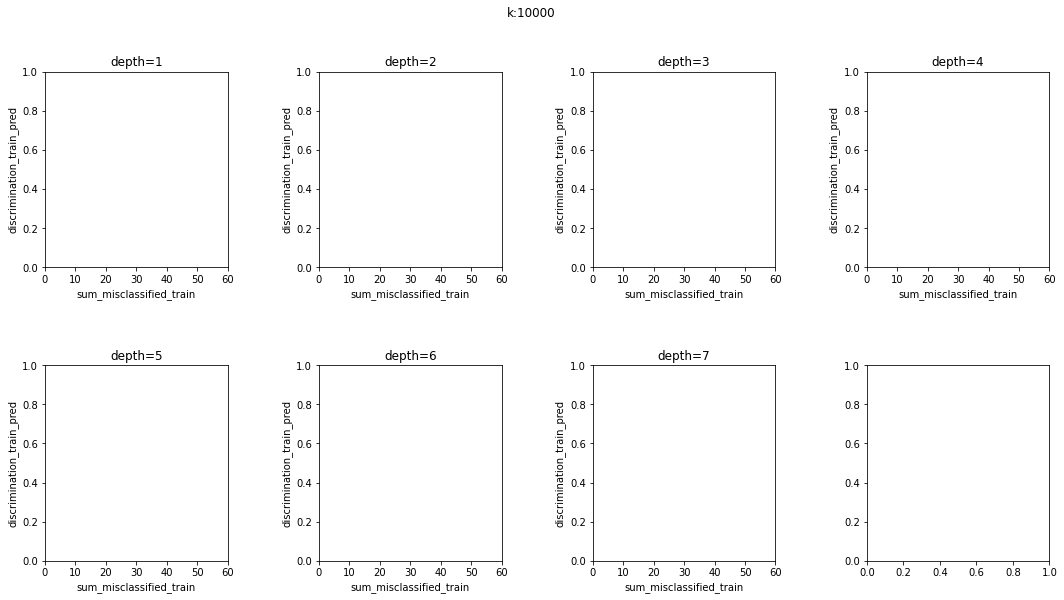

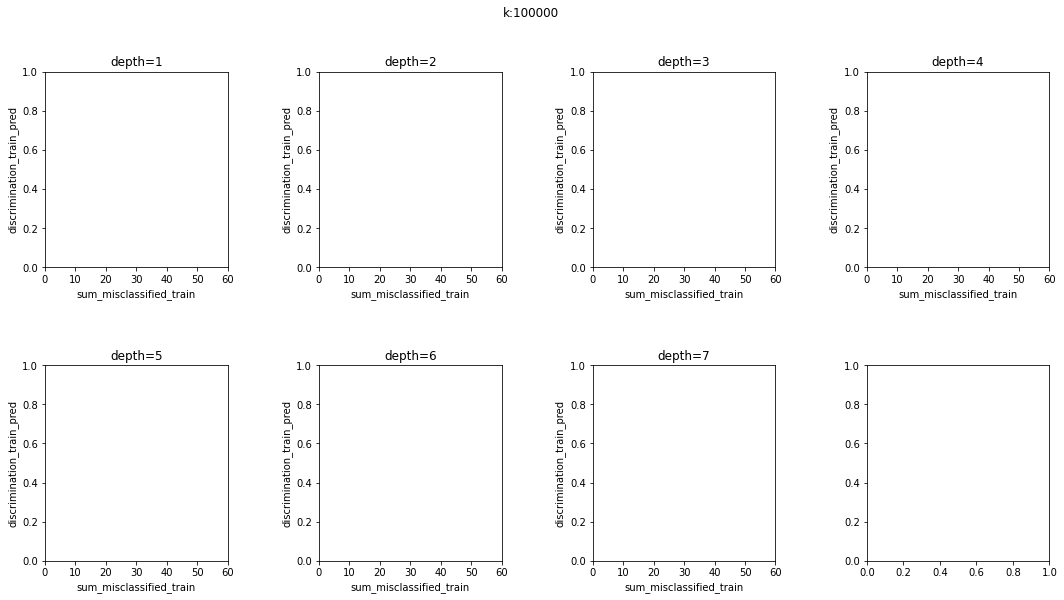

In [24]:
utils.plot_one_scatter_by_depth("sum_misclassified_train", "discrimination_train_pred", result, (0, 60), (0, 1))

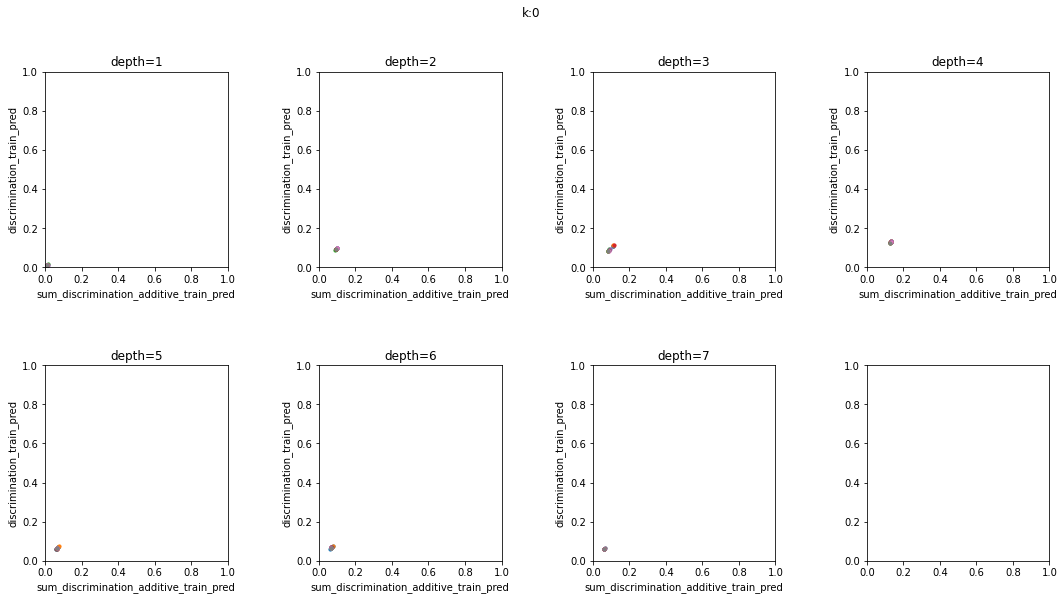

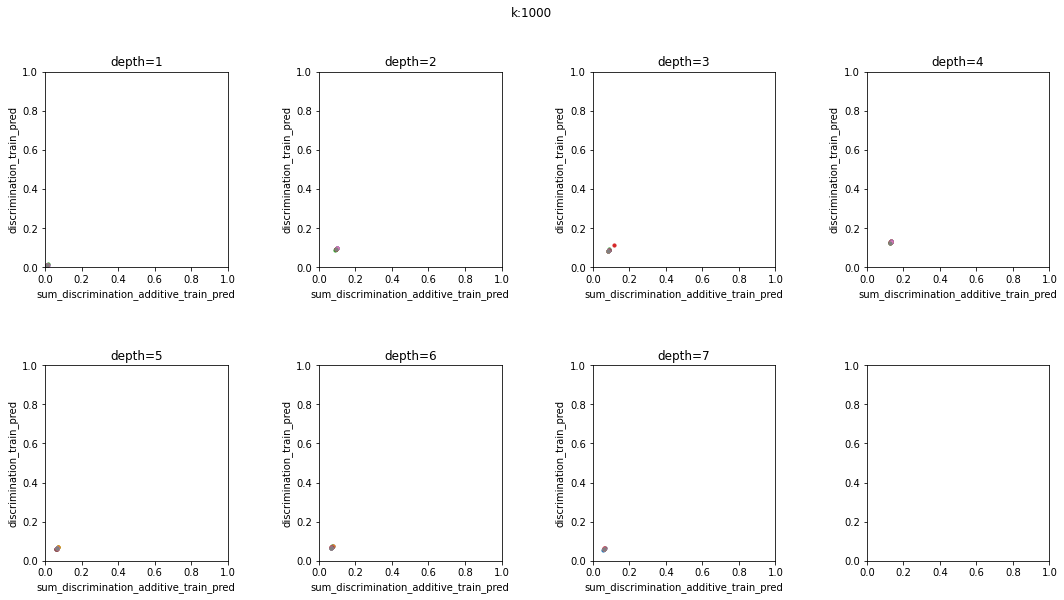

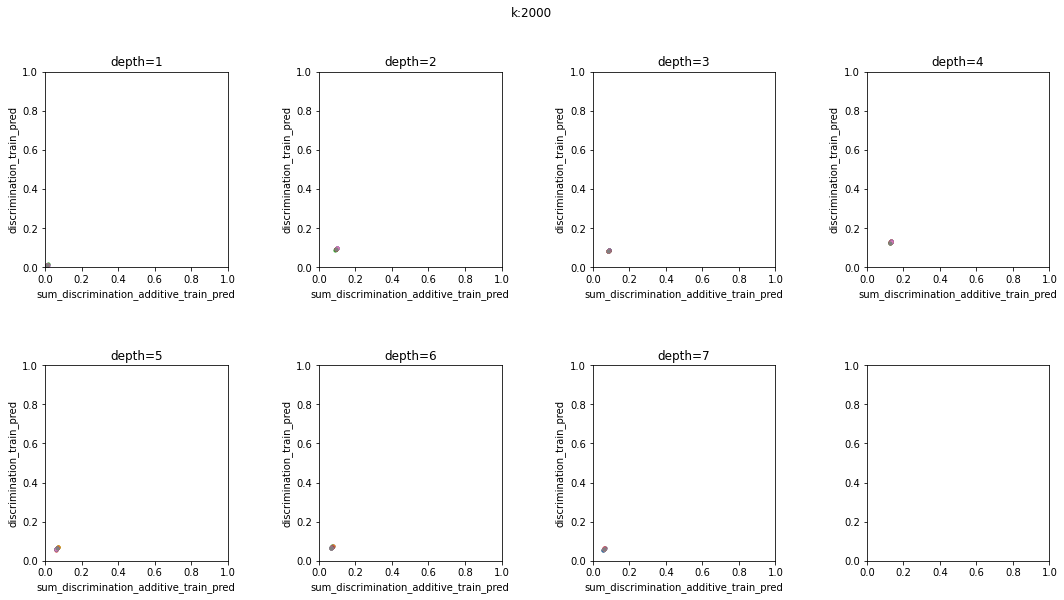

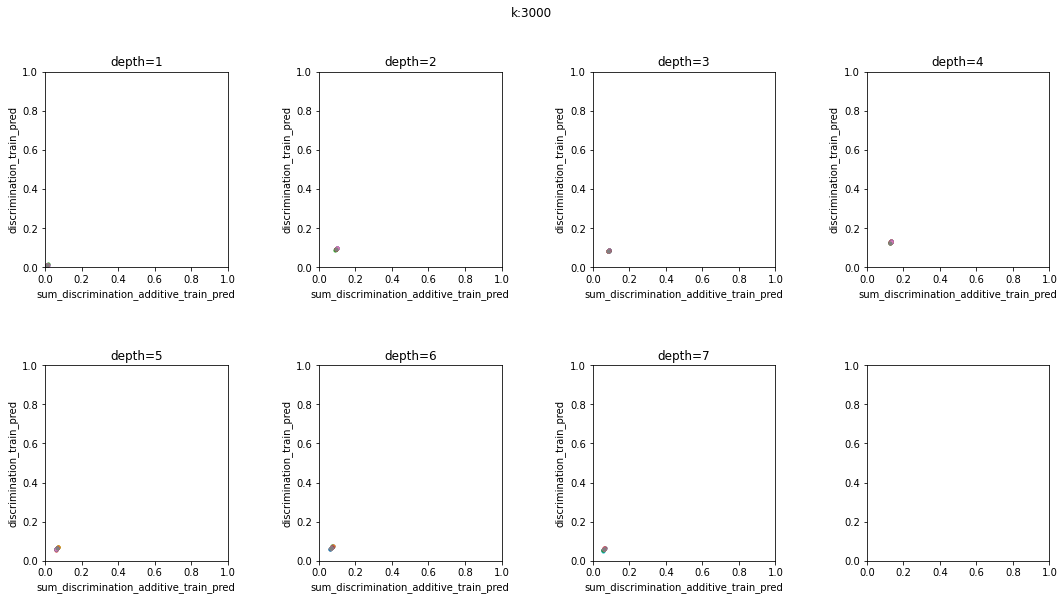

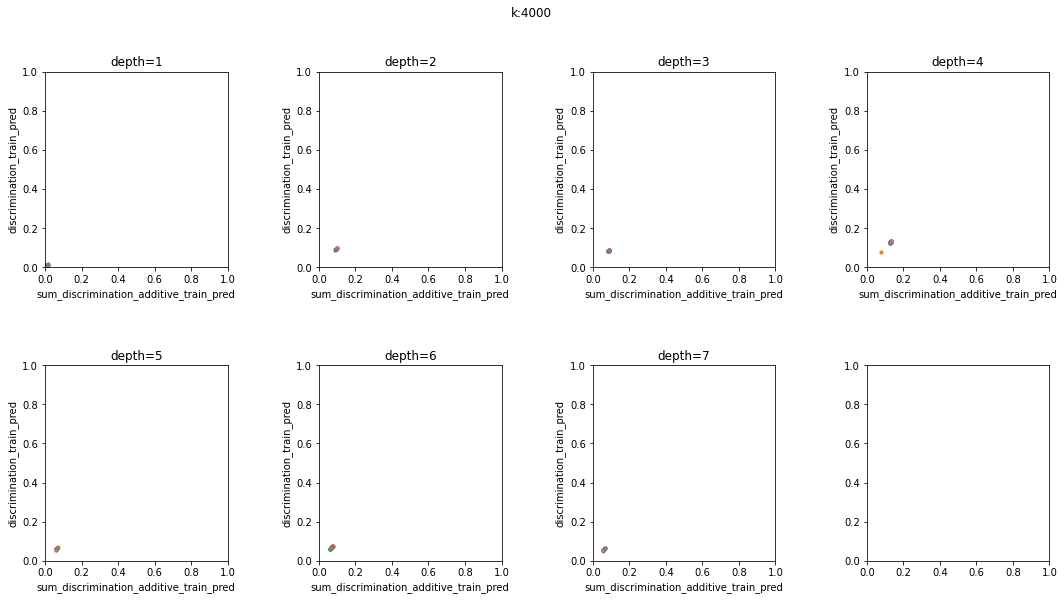

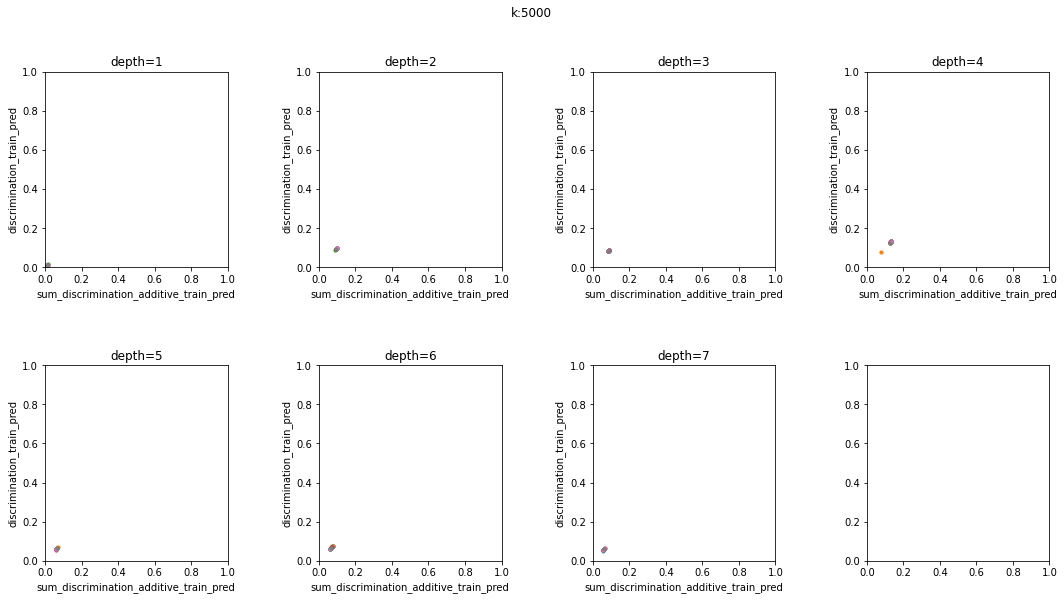

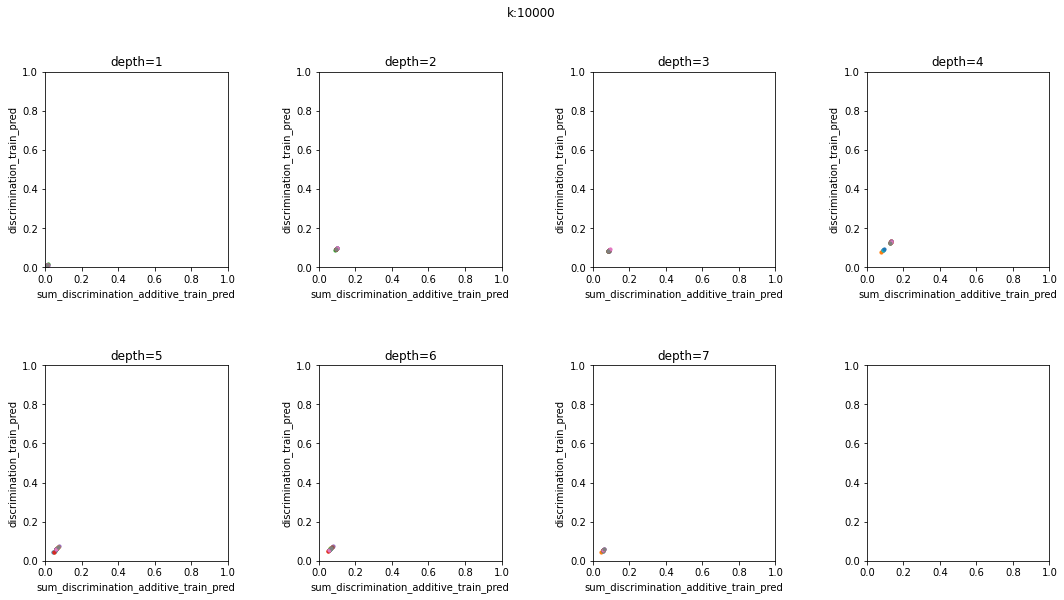

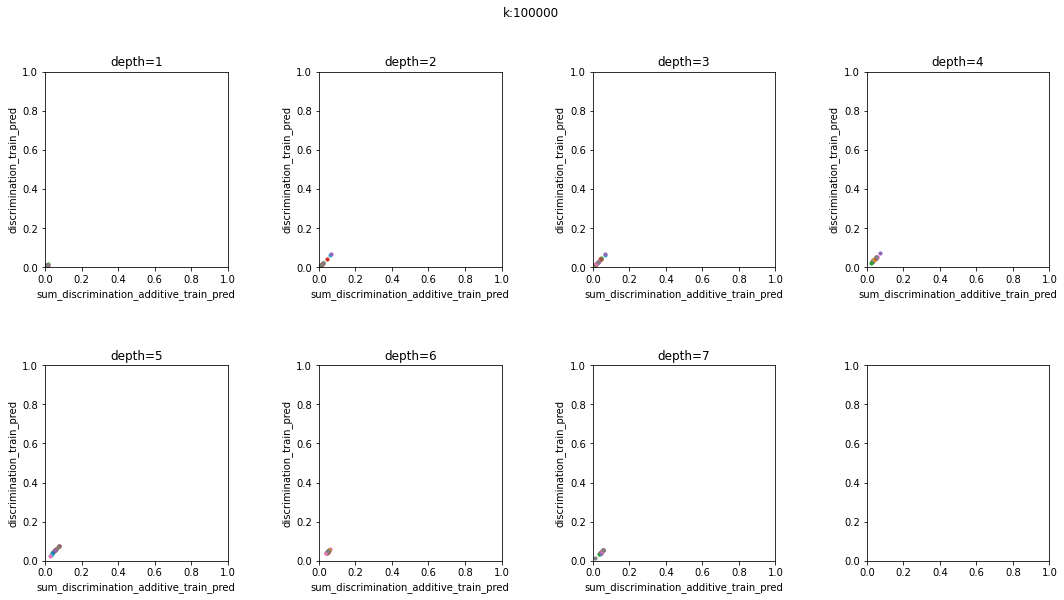

In [25]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, (0, 1), (0, 1))

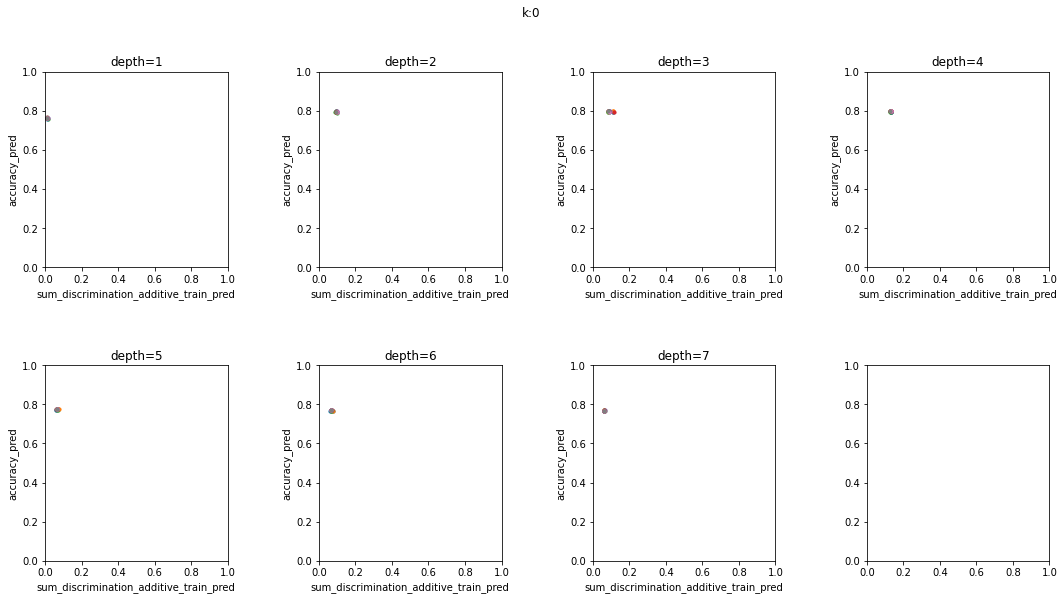

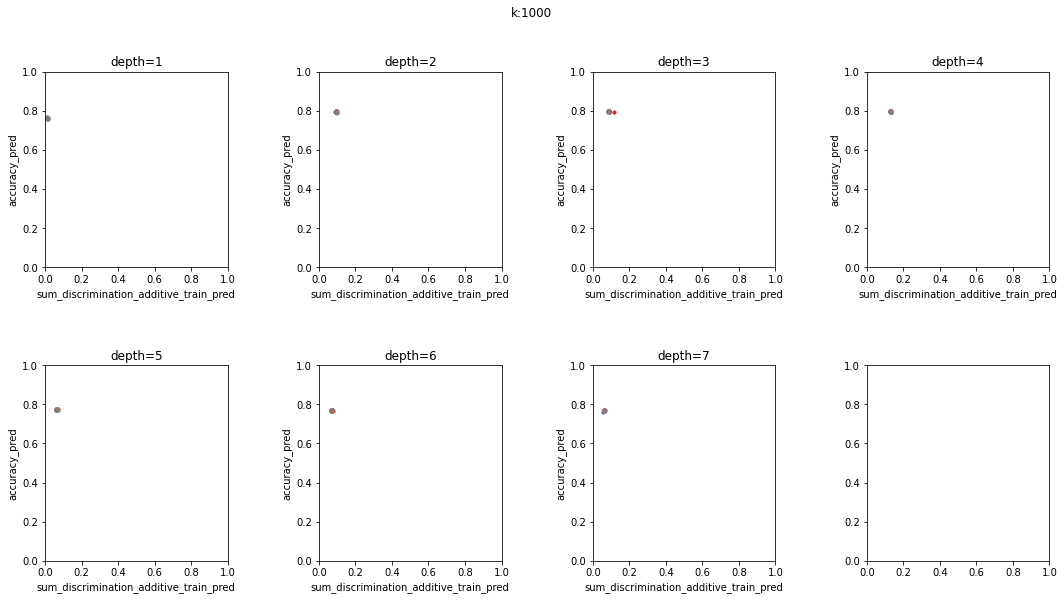

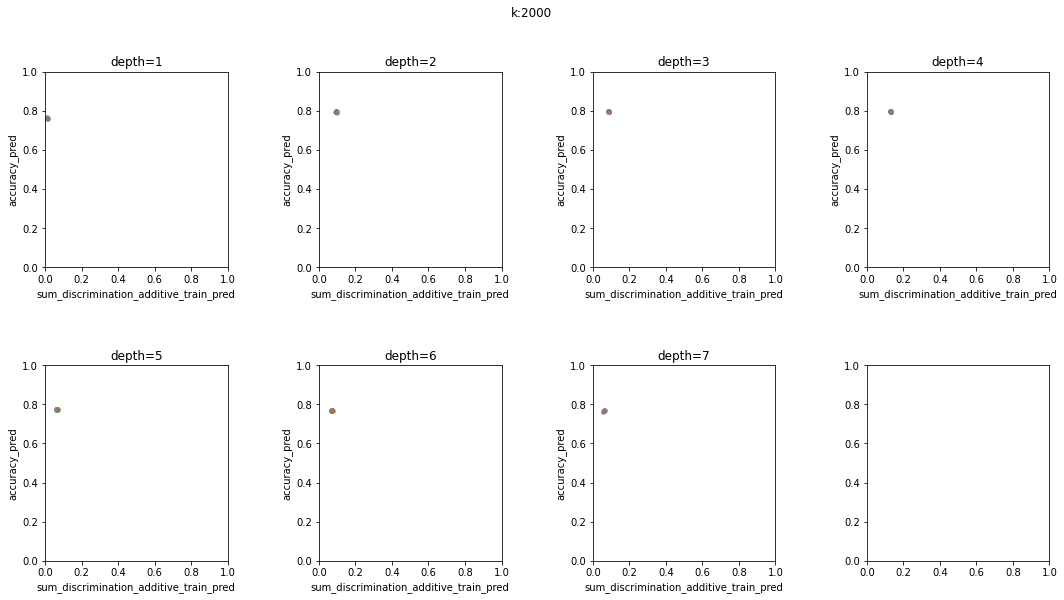

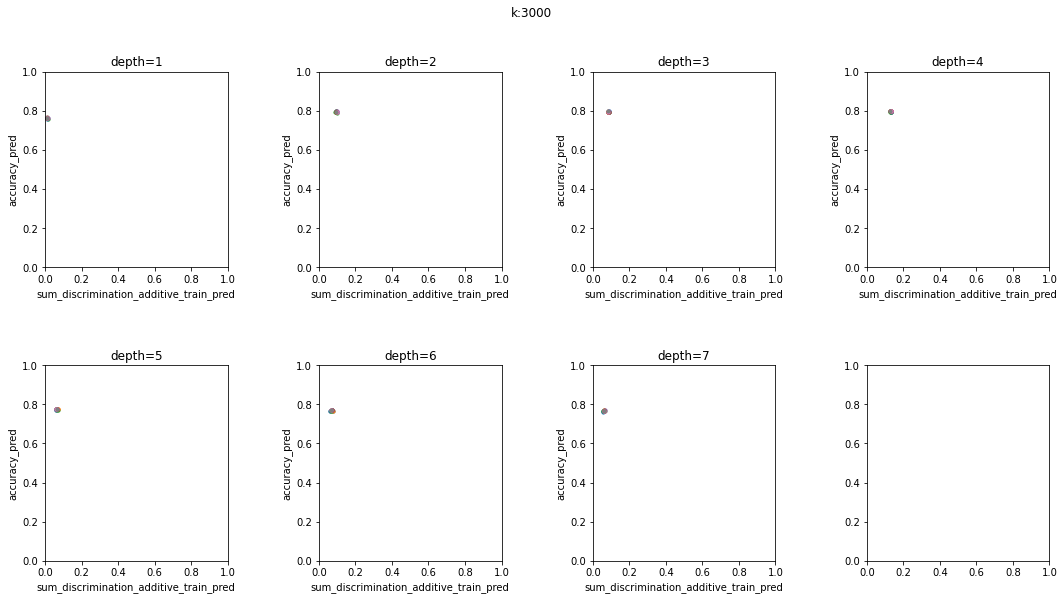

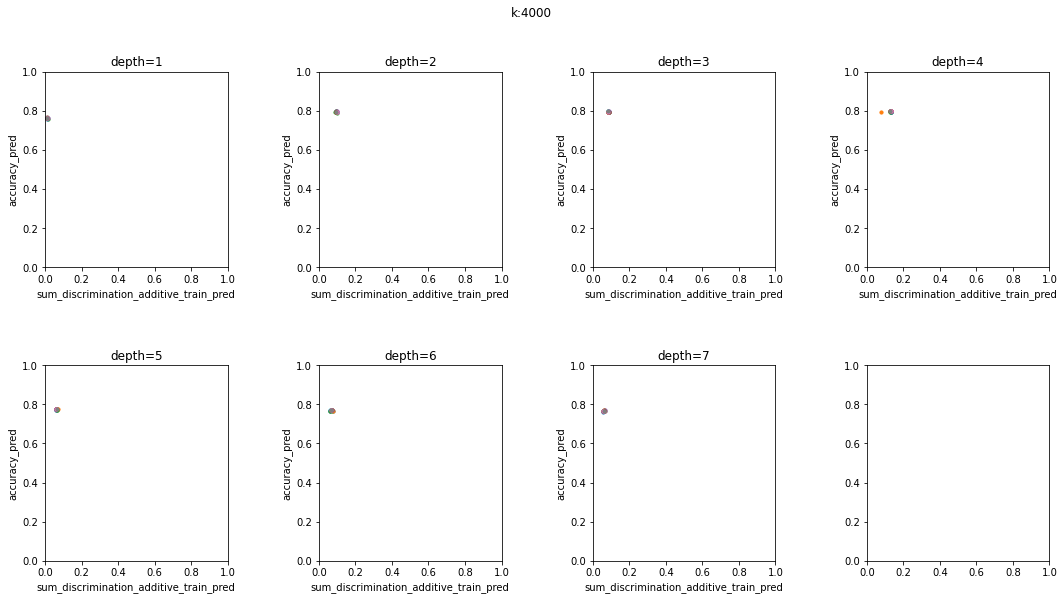

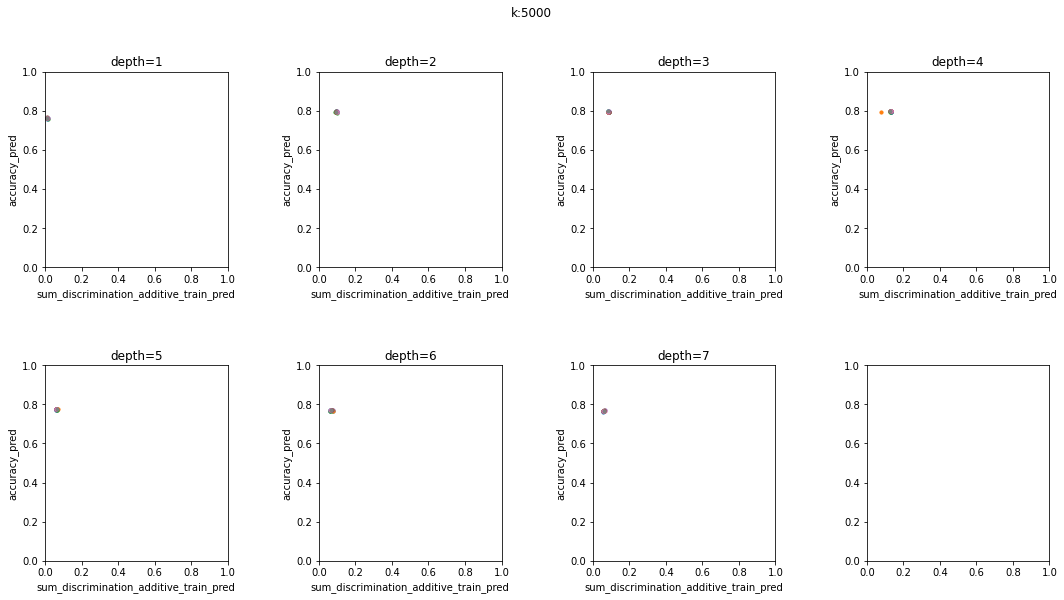

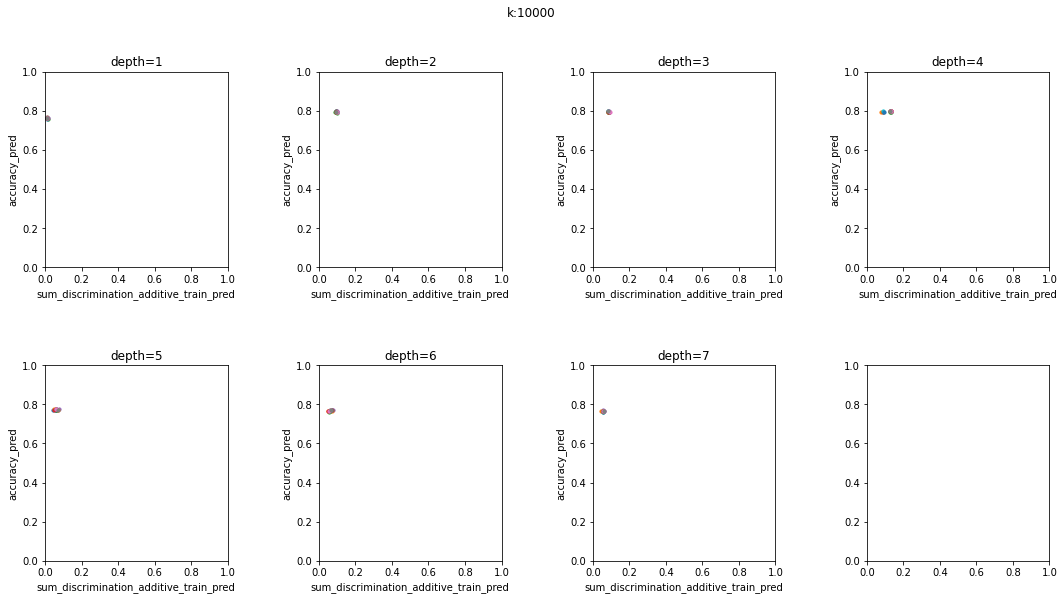

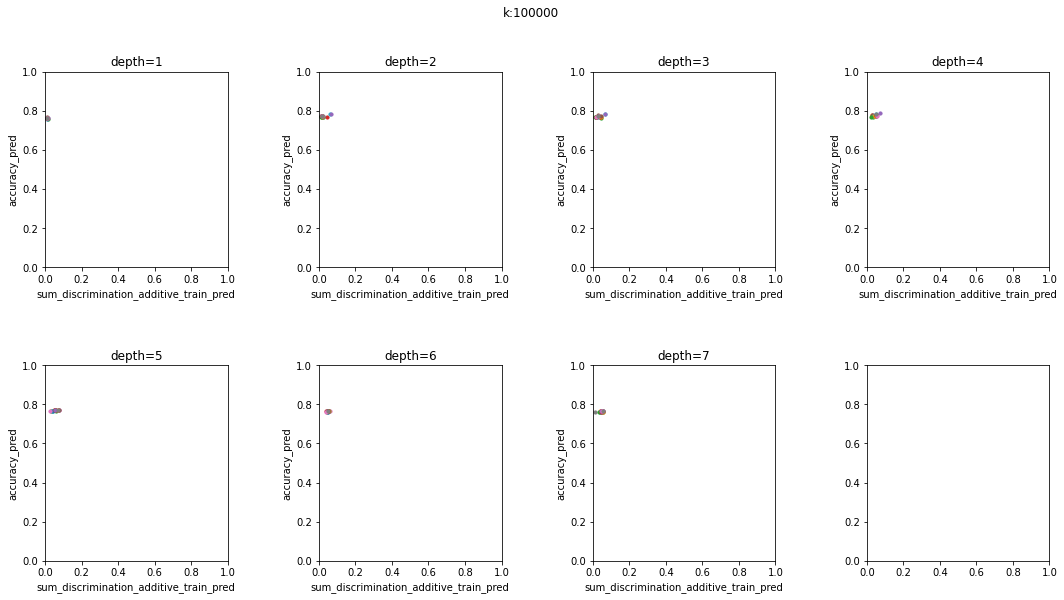

In [26]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "accuracy_pred", result, (0, 1), (0, 1))

<Figure size 648x432 with 0 Axes>

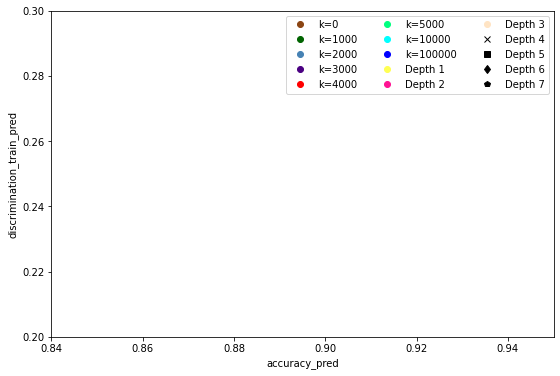

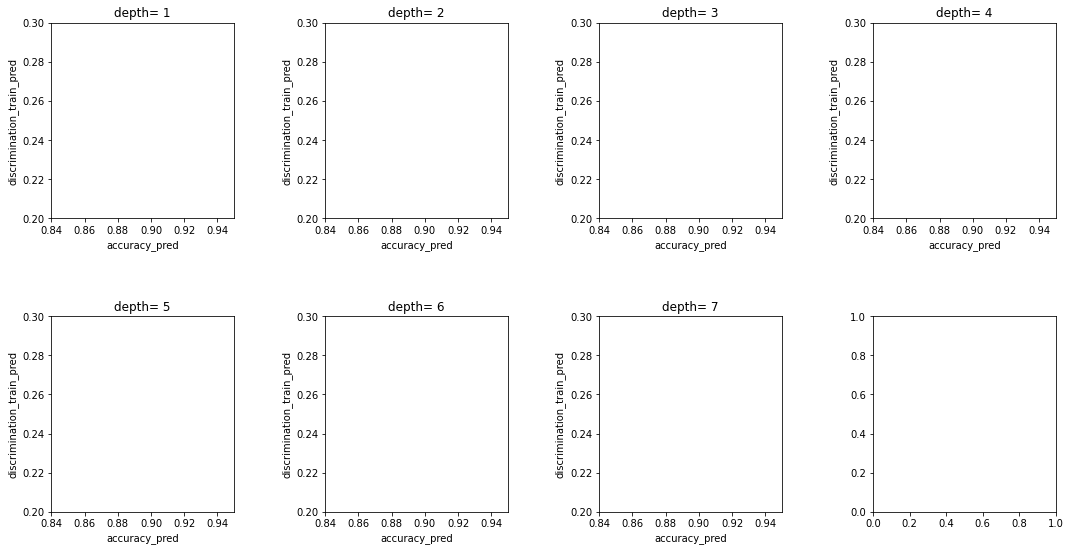

In [27]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_pred", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

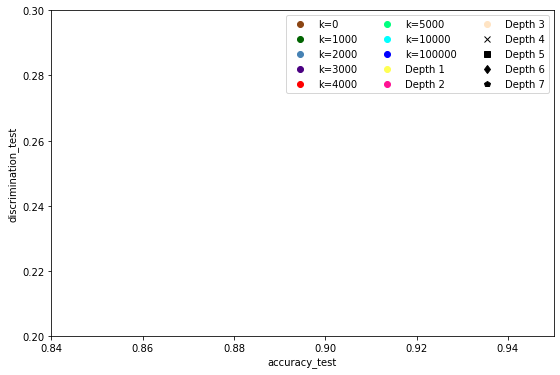

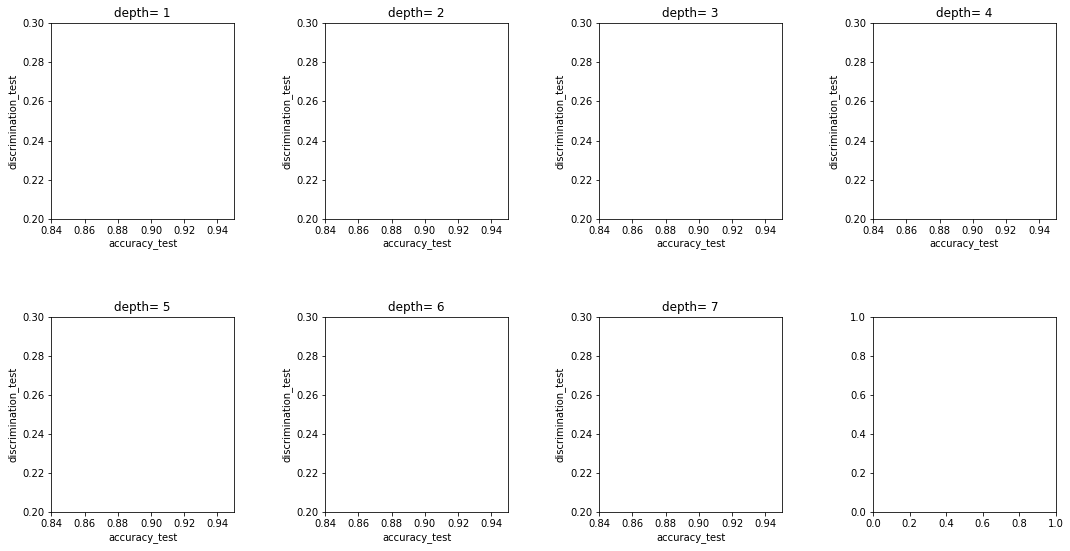

In [28]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

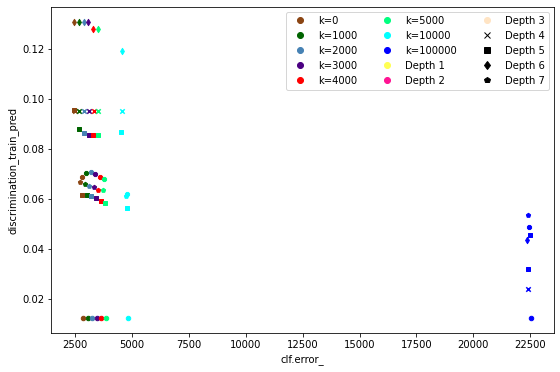

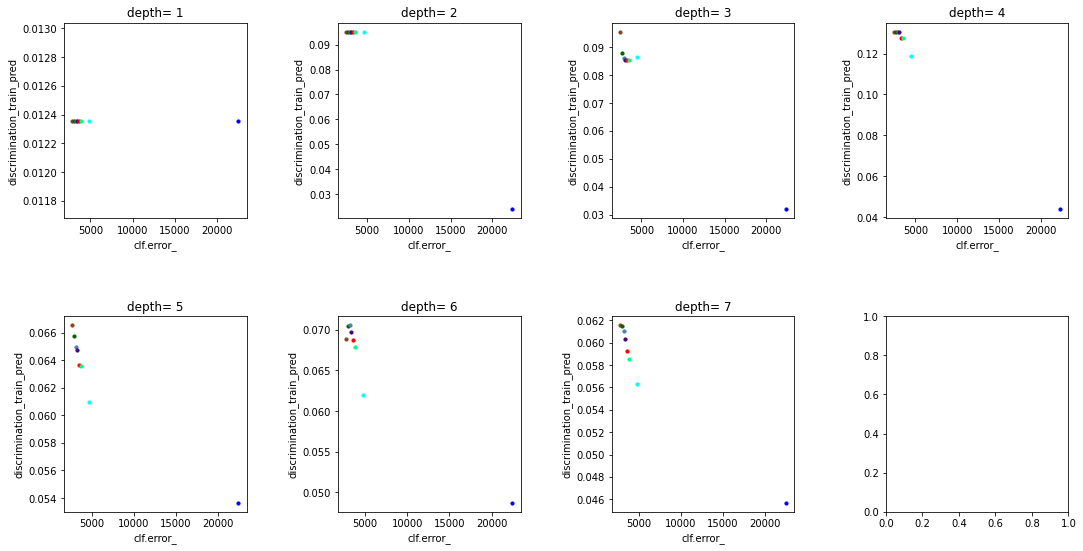

In [29]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

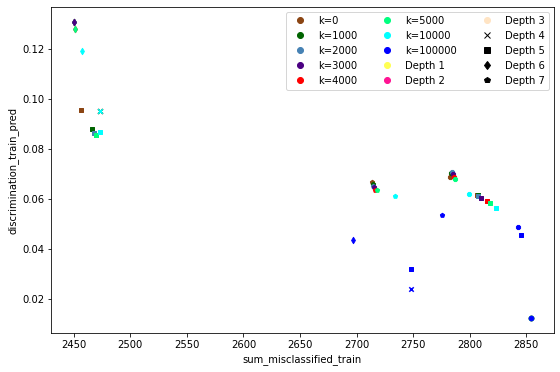

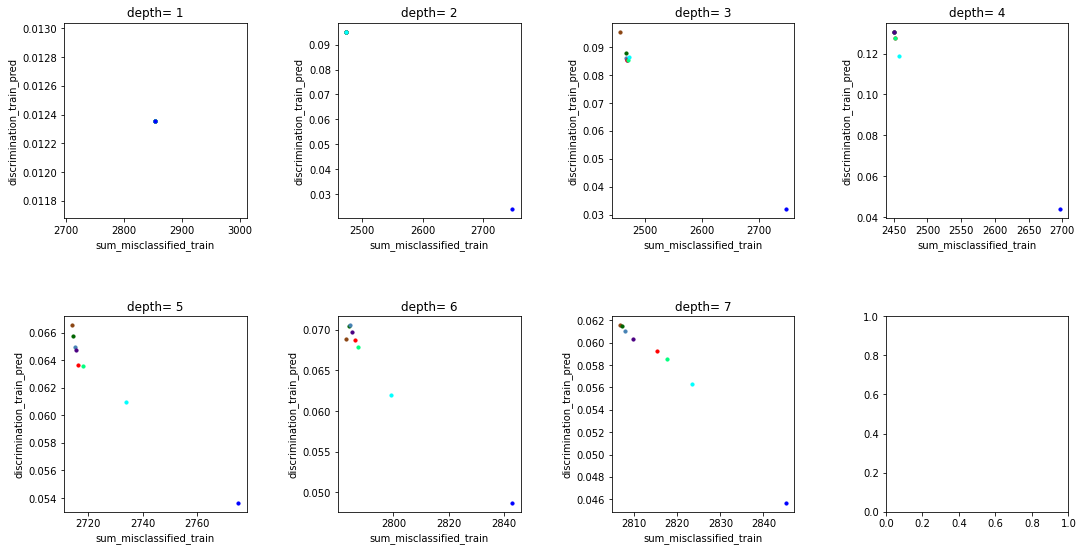

In [30]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

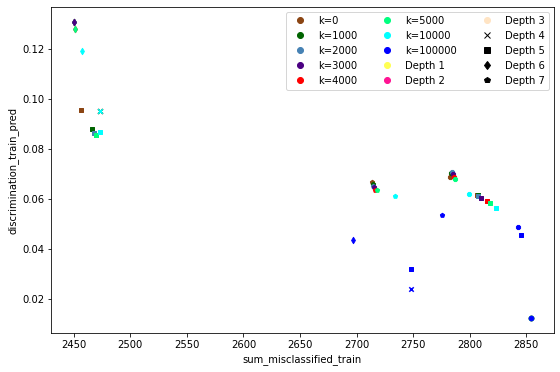

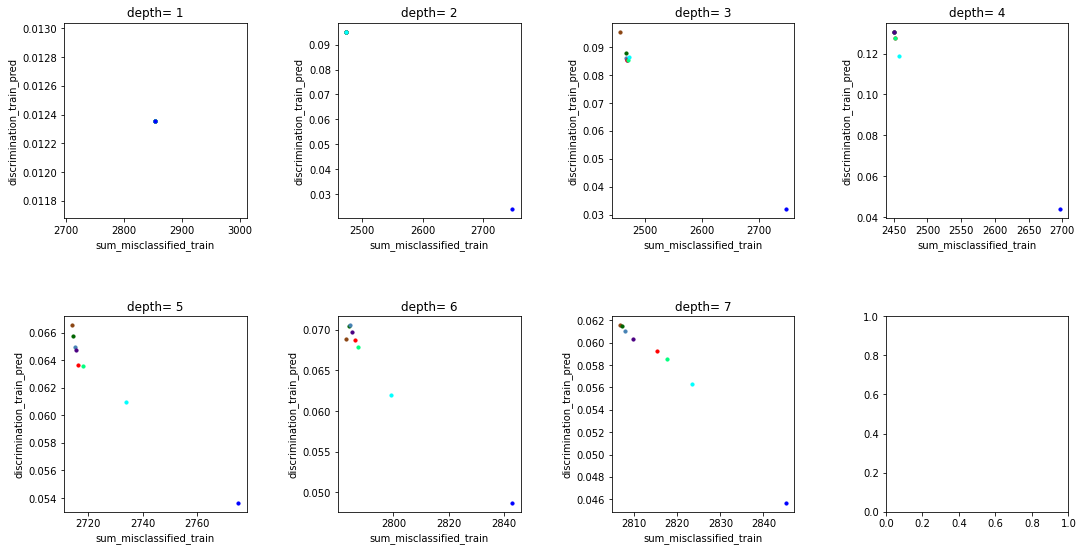

In [31]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

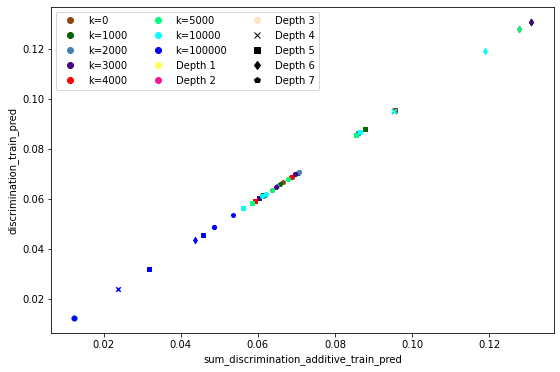

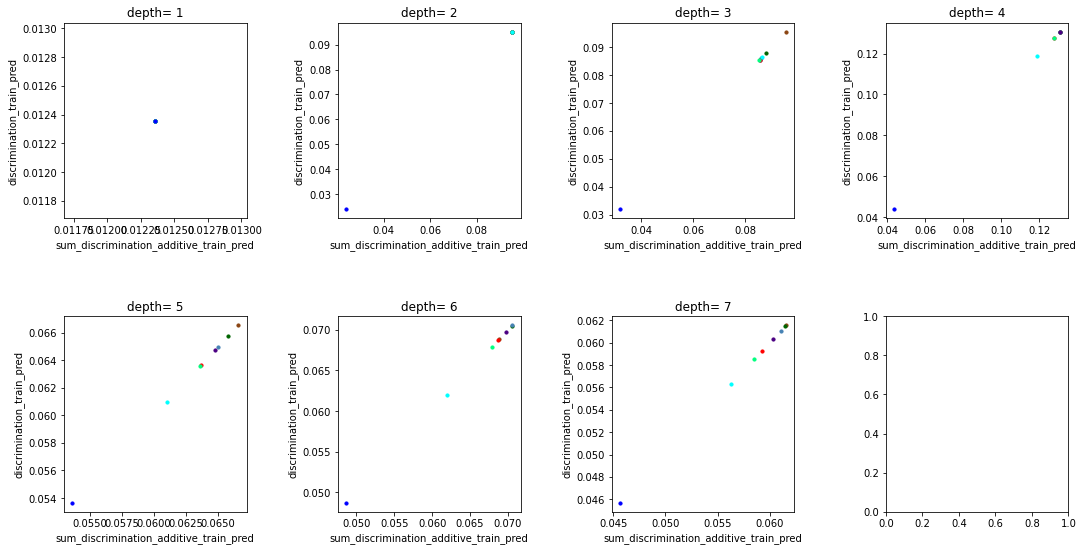

In [32]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

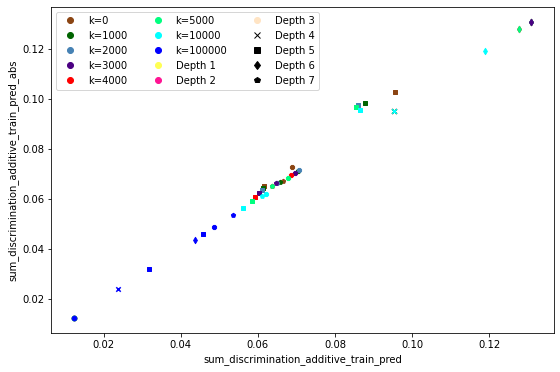

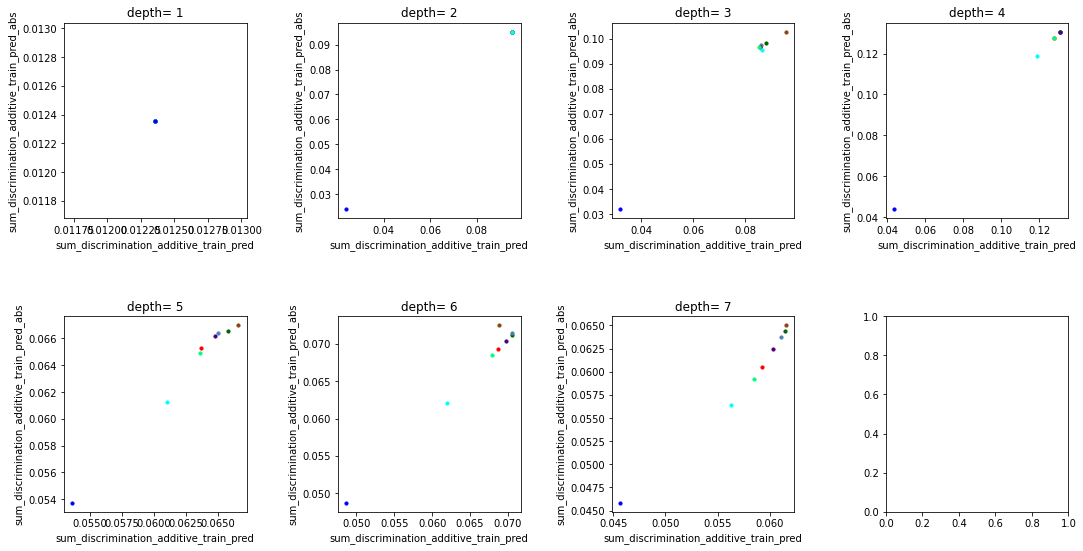

In [33]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)